# Application of Machine Learning for Optimising Cancer Drug Development

In [1]:
!pip install pandas numpy scikit-learn
!pip install tensorflow
!pip install matplotlib seaborn
!pip install rdkit
!pip install -U imbalanced-learn
!pip install xgboost
!pip install scikeras

   ---------------------------------------- 0.0/238.4 kB ? eta -:--:--
   --------------- ------------------------ 92.2/238.4 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------  235.5/238.4 kB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 238.4/238.4 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.3
    Uninstalling imbalanced-learn-0.12.3:
      Successfully uninstalled imbalanced-learn-0.12.3


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, mean_squared_error, r2_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from rdkit import Chem
from rdkit.Chem import Descriptors
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier, MLPRegressor
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from scikeras.wrappers import KerasClassifier

import warnings
warnings.filterwarnings('ignore')

In [7]:
# dataset link: https://tripod.nih.gov/tox21/pubdata/
data = pd.read_csv('C:/Users/adrit/OneDrive/Documents/NTU/NTU MSc Thesis and Dissertation/Final Dissertation Project/tox21-aromatase-p1.csv')

In [9]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70656 entries, 0 to 70655
Data columns (total 55 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SAMPLE_ID         70656 non-null  object 
 1   SAMPLE_DATA_ID    70656 non-null  int64  
 2   PROTOCOL_NAME     70656 non-null  object 
 3   SAMPLE_DATA_TYPE  70656 non-null  object 
 4   ASSAY_OUTCOME     70656 non-null  object 
 5   CURVE_CLASS2      70656 non-null  float64
 6   AC50              39544 non-null  float64
 7   EFFICACY          39544 non-null  float64
 8   ZERO_ACTIVITY     39544 non-null  float64
 9   INF_ACTIVITY      39544 non-null  float64
 10  HILL_COEF         39544 non-null  float64
 11  R2                39544 non-null  float64
 12  P_HILL            39568 non-null  float64
 13  CHANNEL_OUTCOME   70656 non-null  object 
 14  DATA0             70656 non-null  float64
 15  DATA1             70656 non-null  float64
 16  DATA2             70656 non-null  float6

In [11]:
corr_data = data[['AC50','EFFICACY','ZERO_ACTIVITY','INF_ACTIVITY','HILL_COEF','R2','P_HILL', 'DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4', 
                      'DATA5', 'DATA6', 'DATA7', 'DATA8', 'DATA9', 'DATA10', 'DATA11', 'DATA12', 'DATA13', 'DATA14', 'CONC0', 'CONC1', 'CONC2', 'CONC3', 'CONC4', 
                     'CONC5', 'CONC6', 'CONC7', 'CONC8', 'CONC9', 'CONC10', 'CONC11', 'CONC12', 'CONC13', 'CONC14' ]]

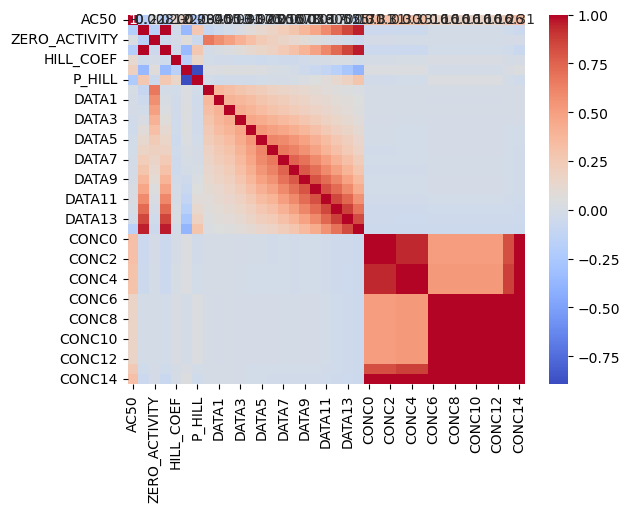

<Figure size 9000x10000 with 0 Axes>

In [13]:
correlation_matrix = corr_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.figure(figsize=(90, 100))
plt.show()

In [15]:
data.shape

(70656, 55)

In [17]:
# Creating two new columns 'DATA_0-15' with the row-wise mean of columns DATA0 to DATA15 and 'CON_0-15' with the row-wise mean of columns CONC0 to CONC15
data['DATA_0-15'] = data[[f'DATA{i}' for i in range(16)]].mean(axis=1) 
data['CON_0-15'] = data[[f'CONC{i}' for i in range(16)]].mean(axis=1)

In [19]:
# Droping the original DATA and CONC columns
data = data.drop(columns=[f'DATA{i}' for i in range(16)] + [f'CONC{i}' for i in range(16)])

In [21]:
data.shape

(70656, 25)

In [23]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70656 entries, 0 to 70655
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SAMPLE_ID         70656 non-null  object 
 1   SAMPLE_DATA_ID    70656 non-null  int64  
 2   PROTOCOL_NAME     70656 non-null  object 
 3   SAMPLE_DATA_TYPE  70656 non-null  object 
 4   ASSAY_OUTCOME     70656 non-null  object 
 5   CURVE_CLASS2      70656 non-null  float64
 6   AC50              39544 non-null  float64
 7   EFFICACY          39544 non-null  float64
 8   ZERO_ACTIVITY     39544 non-null  float64
 9   INF_ACTIVITY      39544 non-null  float64
 10  HILL_COEF         39544 non-null  float64
 11  R2                39544 non-null  float64
 12  P_HILL            39568 non-null  float64
 13  CHANNEL_OUTCOME   70656 non-null  object 
 14  CAS               70656 non-null  object 
 15  PUBCHEM_CID       69762 non-null  float64
 16  PUBCHEM_SID       70656 non-null  int64 

In [33]:
corr_data = data[['AC50','EFFICACY','ZERO_ACTIVITY','INF_ACTIVITY','HILL_COEF','R2','P_HILL', 'DATA_0-15', 'CON_0-15' ]]

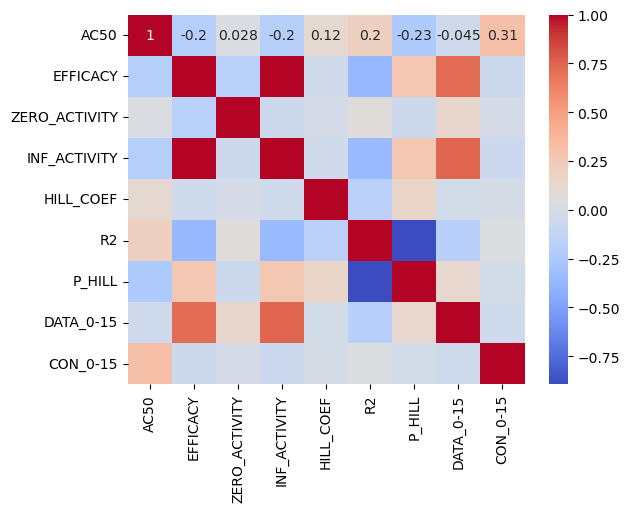

<Figure size 1000x800 with 0 Axes>

In [35]:
correlation_matrix = corr_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.figure(figsize=(10, 8))
plt.show()

In [37]:
#finding missing value
data.replace('', np.nan, inplace=True)
for column in data.columns:
    data[column] = pd.to_numeric(data[column], errors='ignore')

In [39]:
print("\nMissing values in the dataset:")
print(data.isnull().sum())


Missing values in the dataset:
SAMPLE_ID               0
SAMPLE_DATA_ID          0
PROTOCOL_NAME           0
SAMPLE_DATA_TYPE        0
ASSAY_OUTCOME           0
CURVE_CLASS2            0
AC50                31112
EFFICACY            31112
ZERO_ACTIVITY       31112
INF_ACTIVITY        31112
HILL_COEF           31112
R2                  31112
P_HILL              31088
CHANNEL_OUTCOME         0
CAS                     0
PUBCHEM_CID           894
PUBCHEM_SID             0
PURITY_RATING        1848
PURITY_RATING_4M    14070
SAMPLE_NAME             0
SMILES              11118
TOX21_ID            10242
PURITY              70656
DATA_0-15               0
CON_0-15                0
dtype: int64


In [41]:
columns_to_delete = ['PROTOCOL_NAME','CAS','PUBCHEM_CID','PUBCHEM_SID','PURITY','TOX21_ID']
data = data.drop(columns=columns_to_delete)

In [43]:
print("\nMissing values in the dataset:")
print(data.isnull().sum())


Missing values in the dataset:
SAMPLE_ID               0
SAMPLE_DATA_ID          0
SAMPLE_DATA_TYPE        0
ASSAY_OUTCOME           0
CURVE_CLASS2            0
AC50                31112
EFFICACY            31112
ZERO_ACTIVITY       31112
INF_ACTIVITY        31112
HILL_COEF           31112
R2                  31112
P_HILL              31088
CHANNEL_OUTCOME         0
PURITY_RATING        1848
PURITY_RATING_4M    14070
SAMPLE_NAME             0
SMILES              11118
DATA_0-15               0
CON_0-15                0
dtype: int64


In [45]:
Missing_value_deletion = ['AC50','EFFICACY','ZERO_ACTIVITY','INF_ACTIVITY','HILL_COEF','R2','P_HILL','PURITY_RATING','PURITY_RATING_4M','SMILES']
data = data.dropna(subset=Missing_value_deletion)

In [47]:
print("\nMissing values in the cleaned dataset:")
print(data.isnull().sum())


Missing values in the cleaned dataset:
SAMPLE_ID           0
SAMPLE_DATA_ID      0
SAMPLE_DATA_TYPE    0
ASSAY_OUTCOME       0
CURVE_CLASS2        0
AC50                0
EFFICACY            0
ZERO_ACTIVITY       0
INF_ACTIVITY        0
HILL_COEF           0
R2                  0
P_HILL              0
CHANNEL_OUTCOME     0
PURITY_RATING       0
PURITY_RATING_4M    0
SAMPLE_NAME         0
SMILES              0
DATA_0-15           0
CON_0-15            0
dtype: int64


In [49]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 27269 entries, 0 to 70654
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SAMPLE_ID         27269 non-null  object 
 1   SAMPLE_DATA_ID    27269 non-null  int64  
 2   SAMPLE_DATA_TYPE  27269 non-null  object 
 3   ASSAY_OUTCOME     27269 non-null  object 
 4   CURVE_CLASS2      27269 non-null  float64
 5   AC50              27269 non-null  float64
 6   EFFICACY          27269 non-null  float64
 7   ZERO_ACTIVITY     27269 non-null  float64
 8   INF_ACTIVITY      27269 non-null  float64
 9   HILL_COEF         27269 non-null  float64
 10  R2                27269 non-null  float64
 11  P_HILL            27269 non-null  float64
 12  CHANNEL_OUTCOME   27269 non-null  object 
 13  PURITY_RATING     27269 non-null  object 
 14  PURITY_RATING_4M  27269 non-null  object 
 15  SAMPLE_NAME       27269 non-null  object 
 16  SMILES            27269 non-null  object 
 17

In [51]:
data.head()

,SAMPLE_ID,SAMPLE_DATA_ID,SAMPLE_DATA_TYPE,ASSAY_OUTCOME,CURVE_CLASS2,AC50,EFFICACY,ZERO_ACTIVITY,INF_ACTIVITY,HILL_COEF,R2,P_HILL,CHANNEL_OUTCOME,PURITY_RATING,PURITY_RATING_4M,SAMPLE_NAME,SMILES,DATA_0-15,CON_0-15
0,NCGC00160514-01,163970448,viability3,inconclusive antagonist (cytotoxic),-1.2,16.785492,-61.389225,1.542814,-59.846411,2.333173,0.888685,0.000547,active antagonist,A,A,Idebenone,COC1=C(OC)C(=O)C(C)=C(CCCCCCCCCCO)C1=O,-5.830327,0.000006
3,NCGC00018221-08,163971996,viability3,active agonist,4.0,17.439399,23.527909,0.472091,24.000000,0.700000,0.465078,0.209886,inactive,A,A,Cinchophen,O=C(O)c1cc(nc2ccccc12)c3ccccc3,5.134468,0.000011
8,NCGC00091009-05,163916795,antagonist1,inactive,4.0,54.906749,-39.594879,14.908984,-24.685895,4.504470,0.753885,0.215688,inactive,A,A,17-Methyltestosterone,O=C4CC[C@@]3(C)C(CC[C@@H]2[C@@H]3CC[C@@]1(C)[C...,14.438101,0.000010
9,NCGC00164493-01,163913020,antagonist1,inconclusive antagonist (cytotoxic),-1.1,0.149601,-102.169108,-1.618929,-103.788037,4.954917,0.997020,0.000000,active antagonist,A,A,Dipyrithione,[O-][n+]2ccccc2SSc1cccc[n+]1[O-],-53.768429,0.000006
10,NCGC00017049-01,163914250,antagonist1,inactive,4.0,11.358792,12.841653,-3.341653,9.500000,4.954917,0.513154,0.167605,inactive,A,B,Dipyrone,[Na+].[O-]S(=O)(=O)CN(C)C=2C(=O)N(c1ccccc1)N(C...,-2.229121,0.000002


In [53]:
data.shape

(27269, 19)

In [55]:
# Defining a function to map SAMPLE_DATA_TYPE values to 'viability' and 'antagonist'
def merge_classes(data_type):
    if 'viability' in data_type:
        return 'viability'
    elif 'antagonist' in data_type:
        return 'antagonist'
    else:
        return data_type

In [57]:
# Merging classes in SAMPLE_DATA_TYPE column
data['SAMPLE_DATA_TYPE'] = data['SAMPLE_DATA_TYPE'].apply(merge_classes)

In [59]:
data.head()

,SAMPLE_ID,SAMPLE_DATA_ID,SAMPLE_DATA_TYPE,ASSAY_OUTCOME,CURVE_CLASS2,AC50,EFFICACY,ZERO_ACTIVITY,INF_ACTIVITY,HILL_COEF,R2,P_HILL,CHANNEL_OUTCOME,PURITY_RATING,PURITY_RATING_4M,SAMPLE_NAME,SMILES,DATA_0-15,CON_0-15
0,NCGC00160514-01,163970448,viability,inconclusive antagonist (cytotoxic),-1.2,16.785492,-61.389225,1.542814,-59.846411,2.333173,0.888685,0.000547,active antagonist,A,A,Idebenone,COC1=C(OC)C(=O)C(C)=C(CCCCCCCCCCO)C1=O,-5.830327,0.000006
3,NCGC00018221-08,163971996,viability,active agonist,4.0,17.439399,23.527909,0.472091,24.000000,0.700000,0.465078,0.209886,inactive,A,A,Cinchophen,O=C(O)c1cc(nc2ccccc12)c3ccccc3,5.134468,0.000011
8,NCGC00091009-05,163916795,antagonist,inactive,4.0,54.906749,-39.594879,14.908984,-24.685895,4.504470,0.753885,0.215688,inactive,A,A,17-Methyltestosterone,O=C4CC[C@@]3(C)C(CC[C@@H]2[C@@H]3CC[C@@]1(C)[C...,14.438101,0.000010
9,NCGC00164493-01,163913020,antagonist,inconclusive antagonist (cytotoxic),-1.1,0.149601,-102.169108,-1.618929,-103.788037,4.954917,0.997020,0.000000,active antagonist,A,A,Dipyrithione,[O-][n+]2ccccc2SSc1cccc[n+]1[O-],-53.768429,0.000006
10,NCGC00017049-01,163914250,antagonist,inactive,4.0,11.358792,12.841653,-3.341653,9.500000,4.954917,0.513154,0.167605,inactive,A,B,Dipyrone,[Na+].[O-]S(=O)(=O)CN(C)C=2C(=O)N(c1ccccc1)N(C...,-2.229121,0.000002


In [61]:
Categorical_variable = ['SAMPLE_DATA_TYPE','ASSAY_OUTCOME','CHANNEL_OUTCOME','PURITY_RATING','PURITY_RATING_4M']
for var in Categorical_variable:
    print(f"Variable: {var}")
    print(data[var].value_counts())
    print("\n")

Variable: SAMPLE_DATA_TYPE
SAMPLE_DATA_TYPE
antagonist    15435
viability     11834
Name: count, dtype: int64


Variable: ASSAY_OUTCOME
ASSAY_OUTCOME
inactive                               14885
inconclusive antagonist (cytotoxic)     5151
active agonist                          2565
active antagonist                       1760
inconclusive agonist                    1216
inconclusive antagonist                 1185
inconclusive agonist (cytotoxic)         350
inconclusive                             157
Name: count, dtype: int64


Variable: CHANNEL_OUTCOME
CHANNEL_OUTCOME
inactive                   15626
active antagonist           6054
inconclusive antagonist     2489
active agonist              1834
inconclusive agonist        1163
inconclusive                 103
Name: count, dtype: int64


Variable: PURITY_RATING
PURITY_RATING
A      23178
F       1126
B        579
Ac       504
Z        495
I        364
C        287
AC       258
D        252
Cc        64
Bc        38
Fc        37


In [63]:
# To avoid Word Case issue in PURITY_RATING and PURITY_RATING_4M column
data['PURITY_RATING'] = data['PURITY_RATING'].str.upper()
data['PURITY_RATING_4M'] = data['PURITY_RATING_4M'].str.upper()

In [65]:
for var in Categorical_variable:
    print(f"Variable: {var}")
    print(data[var].value_counts())
    print("\n")

Variable: SAMPLE_DATA_TYPE
SAMPLE_DATA_TYPE
antagonist    15435
viability     11834
Name: count, dtype: int64


Variable: ASSAY_OUTCOME
ASSAY_OUTCOME
inactive                               14885
inconclusive antagonist (cytotoxic)     5151
active agonist                          2565
active antagonist                       1760
inconclusive agonist                    1216
inconclusive antagonist                 1185
inconclusive agonist (cytotoxic)         350
inconclusive                             157
Name: count, dtype: int64


Variable: CHANNEL_OUTCOME
CHANNEL_OUTCOME
inactive                   15626
active antagonist           6054
inconclusive antagonist     2489
active agonist              1834
inconclusive agonist        1163
inconclusive                 103
Name: count, dtype: int64


Variable: PURITY_RATING
PURITY_RATING
A      23178
F       1126
AC       762
B        579
Z        495
I        364
C        287
D        252
CC        68
BC        50
FC        46
FNS       38


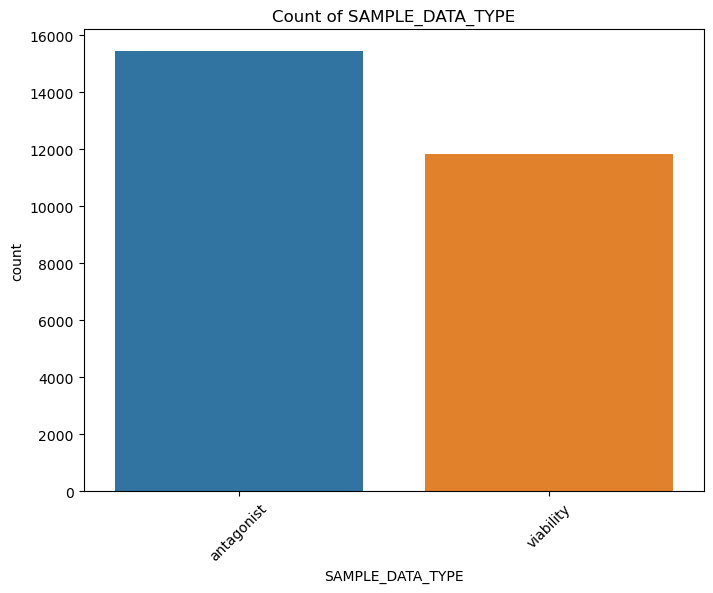

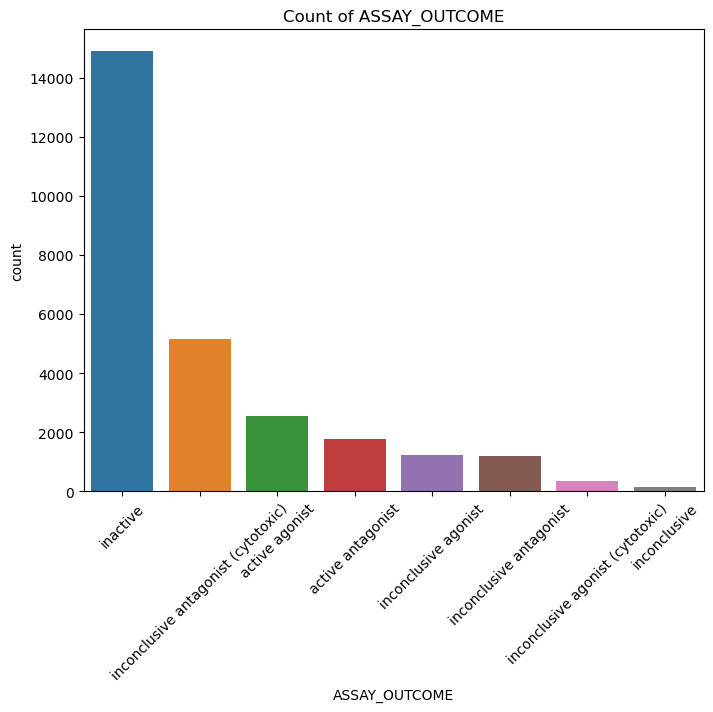

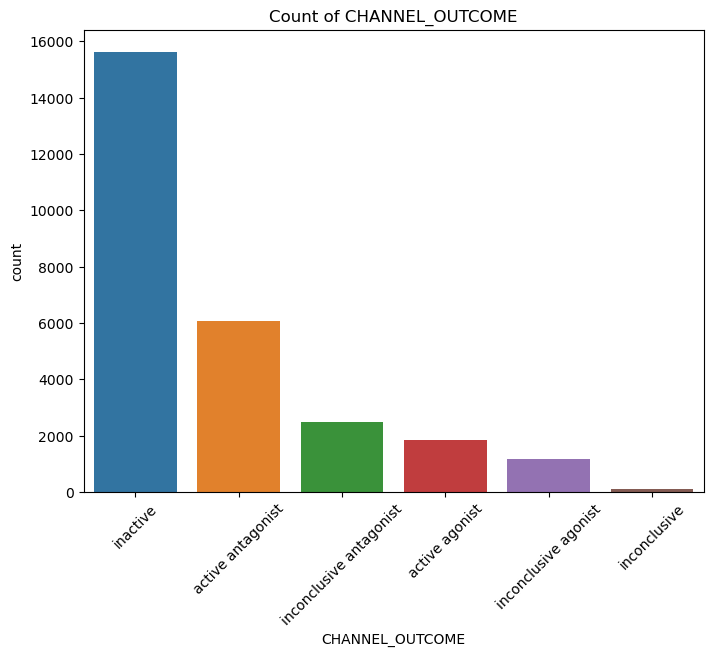

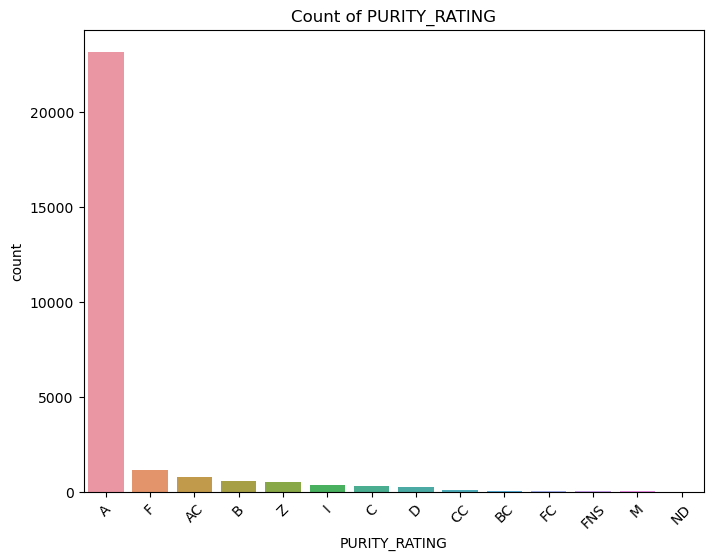

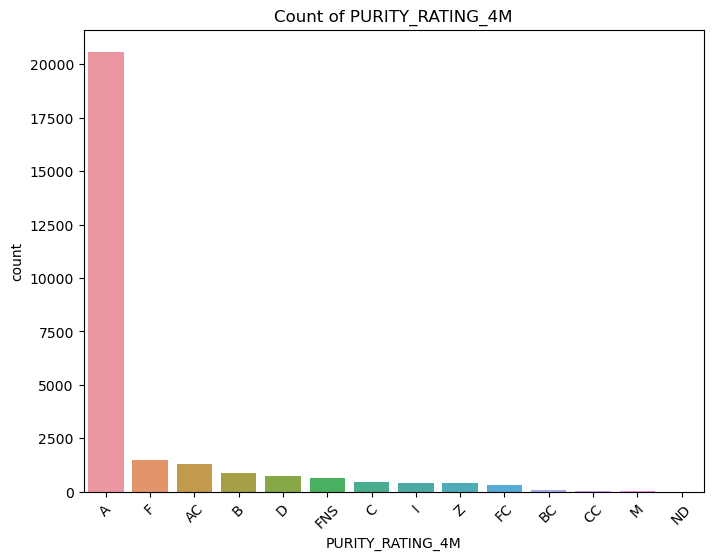

In [67]:
# Plotting counts of each category for each categorical variable
for var in Categorical_variable:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=data, x=var, order=data[var].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f"Count of {var}")
    plt.show()

In [69]:
# continuous data summary
conti_data = data[['AC50','EFFICACY','ZERO_ACTIVITY','INF_ACTIVITY','HILL_COEF','R2','P_HILL', 'DATA_0-15', 'CON_0-15']]
conti_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AC50,27269.0,23.170399,24.190568,1.668310e-04,1.219715,15.355304,34.166596,189.582682
EFFICACY,27269.0,-15.354070,57.344530,-1.876457e+02,-42.995234,-9.900541,15.195414,1390.748596
ZERO_ACTIVITY,27269.0,-0.030133,6.849890,-1.081253e+02,-2.500000,-0.336003,2.020398,124.321680
INF_ACTIVITY,27269.0,-15.384203,56.568305,-1.678451e+02,-41.900471,-5.053052,12.000000,1404.722172
HILL_COEF,27269.0,3.014357,1.655023,2.000000e-01,1.464100,3.065448,4.954917,4.954917
R2,27269.0,0.671259,0.218900,3.009858e-01,0.469784,0.663487,0.891463,0.999184
P_HILL,27269.0,0.114780,0.126261,0.000000e+00,0.000627,0.063499,0.217765,0.899602
DATA_0-15,27269.0,-1.436834,13.779793,-9.971208e+01,-4.753053,-0.960866,2.079909,248.891392
CON_0-15,27269.0,0.000009,0.000003,5.529552e-07,0.000006,0.000011,0.000011,0.000111


array([[<Axes: title={'center': 'AC50'}>,
        <Axes: title={'center': 'EFFICACY'}>,
        <Axes: title={'center': 'ZERO_ACTIVITY'}>],
       [<Axes: title={'center': 'INF_ACTIVITY'}>,
        <Axes: title={'center': 'HILL_COEF'}>,
        <Axes: title={'center': 'R2'}>],
       [<Axes: title={'center': 'P_HILL'}>,
        <Axes: title={'center': 'DATA_0-15'}>,
        <Axes: title={'center': 'CON_0-15'}>]], dtype=object)

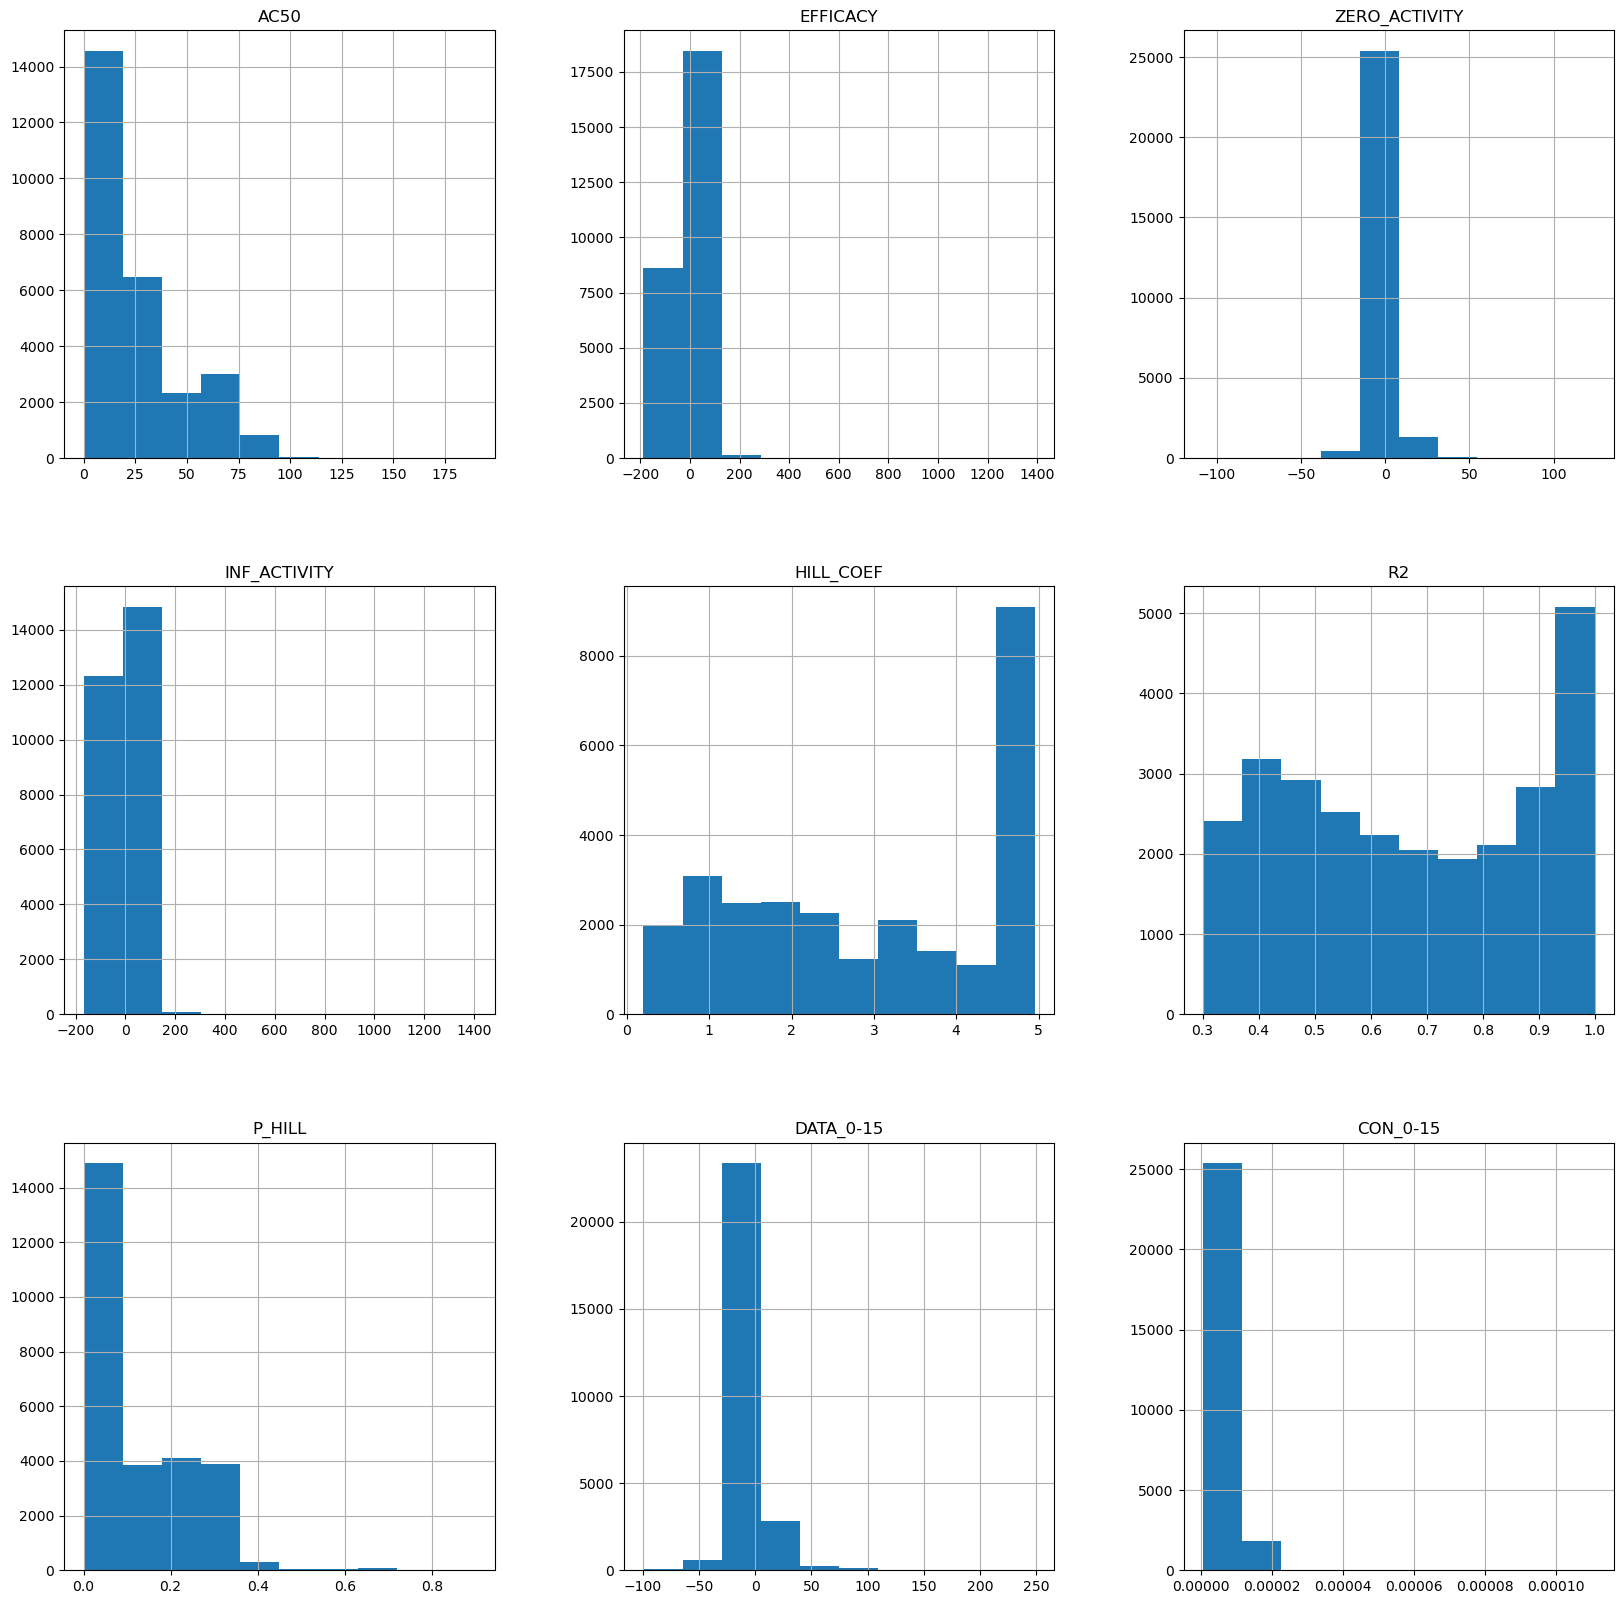

In [71]:
# continuous data distribution graph to visualise normality
conti_data.hist(figsize = (20, 20))

### Column CLASS creation

In [73]:
# Creating CLASS variable
data['AC50'] = data['AC50'] * 1000

conditions = [
    (data['AC50'] < 1000),
    (data['AC50'] > 10000)
]
choices = ['active', 'inactive']
data['CLASS'] = pd.Series(['intermediate'] * len(data))  # Default to 'intermediate'
data.loc[conditions[0], 'CLASS'] = choices[0]
data.loc[conditions[1], 'CLASS'] = choices[1]

In [75]:
data.head()

,SAMPLE_ID,SAMPLE_DATA_ID,SAMPLE_DATA_TYPE,ASSAY_OUTCOME,CURVE_CLASS2,AC50,EFFICACY,ZERO_ACTIVITY,INF_ACTIVITY,HILL_COEF,R2,P_HILL,CHANNEL_OUTCOME,PURITY_RATING,PURITY_RATING_4M,SAMPLE_NAME,SMILES,DATA_0-15,CON_0-15,CLASS
0,NCGC00160514-01,163970448,viability,inconclusive antagonist (cytotoxic),-1.2,16785.492000,-61.389225,1.542814,-59.846411,2.333173,0.888685,0.000547,active antagonist,A,A,Idebenone,COC1=C(OC)C(=O)C(C)=C(CCCCCCCCCCO)C1=O,-5.830327,0.000006,inactive
3,NCGC00018221-08,163971996,viability,active agonist,4.0,17439.398690,23.527909,0.472091,24.000000,0.700000,0.465078,0.209886,inactive,A,A,Cinchophen,O=C(O)c1cc(nc2ccccc12)c3ccccc3,5.134468,0.000011,inactive
8,NCGC00091009-05,163916795,antagonist,inactive,4.0,54906.749450,-39.594879,14.908984,-24.685895,4.504470,0.753885,0.215688,inactive,A,A,17-Methyltestosterone,O=C4CC[C@@]3(C)C(CC[C@@H]2[C@@H]3CC[C@@]1(C)[C...,14.438101,0.000010,inactive
9,NCGC00164493-01,163913020,antagonist,inconclusive antagonist (cytotoxic),-1.1,149.600855,-102.169108,-1.618929,-103.788037,4.954917,0.997020,0.000000,active antagonist,A,A,Dipyrithione,[O-][n+]2ccccc2SSc1cccc[n+]1[O-],-53.768429,0.000006,active
10,NCGC00017049-01,163914250,antagonist,inactive,4.0,11358.792230,12.841653,-3.341653,9.500000,4.954917,0.513154,0.167605,inactive,A,B,Dipyrone,[Na+].[O-]S(=O)(=O)CN(C)C=2C(=O)N(c1ccccc1)N(C...,-2.229121,0.000002,inactive


In [77]:
# Defining categories for each column
categories = {
    'SAMPLE_DATA_TYPE': ['antagonist', 'viability'],
    'ASSAY_OUTCOME': ['active agonist', 'active antagonist', 'inactive', 'inconclusive', 'inconclusive agonist', 'inconclusive agonist (cytotoxic)', 'inconclusive antagonist', 'inconclusive antagonist (cytotoxic)'],
    'CHANNEL_OUTCOME': ['active agonist', 'active antagonist', 'inactive', 'inconclusive', 'inconclusive agonist', 'inconclusive antagonist'],
    'PURITY_RATING': ['A', 'AC', 'B', 'BC', 'C', 'CC', 'D', 'F', 'FC', 'FNS', 'I', 'M', 'ND', 'W', 'Z'],
    'PURITY_RATING_4M': ['A', 'AC', 'B', 'BC', 'C', 'CC', 'D', 'F', 'FC', 'FNS', 'I', 'M', 'ND', 'W', 'Z'],
    'CLASS': ['active', 'inactive', 'intermediate']
}

In [79]:
# Checking for unexpected values before transformation, this process is applied to validate any anomalies before Label encoding
for column in categories.keys():
    unexpected_values = set(data[column].dropna().unique()) - set(categories[column])
    if unexpected_values:
        print(f"Unexpected values in {column}: {unexpected_values}")
    else:
        print(f"No unexpected values in {column}")

No unexpected values in SAMPLE_DATA_TYPE
No unexpected values in ASSAY_OUTCOME
No unexpected values in CHANNEL_OUTCOME
No unexpected values in PURITY_RATING
No unexpected values in PURITY_RATING_4M
No unexpected values in CLASS


In [81]:
# Replacing unexpected values with NaN
for column, cats in categories.items():
    data[column] = data[column].apply(lambda x: x if x in cats else np.nan)

In [83]:
# Checking for values in each category after replacement
for column in categories.keys():
    unique_values = set(data[column].dropna().unique())
    print(f"Unique values in {column} after replacement: {unique_values}")

Unique values in SAMPLE_DATA_TYPE after replacement: {'antagonist', 'viability'}
Unique values in ASSAY_OUTCOME after replacement: {'inconclusive', 'active agonist', 'inactive', 'inconclusive agonist (cytotoxic)', 'inconclusive agonist', 'inconclusive antagonist', 'inconclusive antagonist (cytotoxic)', 'active antagonist'}
Unique values in CHANNEL_OUTCOME after replacement: {'inconclusive', 'active agonist', 'inactive', 'inconclusive agonist', 'inconclusive antagonist', 'active antagonist'}
Unique values in PURITY_RATING after replacement: {'FNS', 'B', 'F', 'C', 'CC', 'A', 'ND', 'AC', 'Z', 'FC', 'M', 'D', 'I', 'BC'}
Unique values in PURITY_RATING_4M after replacement: {'FNS', 'B', 'F', 'C', 'CC', 'A', 'ND', 'AC', 'Z', 'FC', 'M', 'D', 'I', 'BC'}
Unique values in CLASS after replacement: {'intermediate', 'inactive', 'active'}


In [85]:
# Dropping rows with NaN values
data.dropna(subset=categories.keys(), inplace=True)

In [87]:
# Label encode categorical features
label_encoders = {}
for column, cats in categories.items():
    le = LabelEncoder()
    le.fit(cats)
    data[column] = le.transform(data[column])
    label_encoders[column] = le
    print(f"Classes in {column}: {le.classes_}")

Classes in SAMPLE_DATA_TYPE: ['antagonist' 'viability']
Classes in ASSAY_OUTCOME: ['active agonist' 'active antagonist' 'inactive' 'inconclusive'
 'inconclusive agonist' 'inconclusive agonist (cytotoxic)'
 'inconclusive antagonist' 'inconclusive antagonist (cytotoxic)']
Classes in CHANNEL_OUTCOME: ['active agonist' 'active antagonist' 'inactive' 'inconclusive'
 'inconclusive agonist' 'inconclusive antagonist']
Classes in PURITY_RATING: ['A' 'AC' 'B' 'BC' 'C' 'CC' 'D' 'F' 'FC' 'FNS' 'I' 'M' 'ND' 'W' 'Z']
Classes in PURITY_RATING_4M: ['A' 'AC' 'B' 'BC' 'C' 'CC' 'D' 'F' 'FC' 'FNS' 'I' 'M' 'ND' 'W' 'Z']
Classes in CLASS: ['active' 'inactive' 'intermediate']


In [89]:
categorical_columns = ['SAMPLE_DATA_TYPE', 'ASSAY_OUTCOME', 'CHANNEL_OUTCOME', 'PURITY_RATING', 'PURITY_RATING_4M', 'CLASS']
for column in categorical_columns:
    unique_values = data[column].unique()
    print(f"Unique values in {column}: {unique_values}")

Unique values in SAMPLE_DATA_TYPE: [1 0]
Unique values in ASSAY_OUTCOME: [7 0 2 1 4 6 3 5]
Unique values in CHANNEL_OUTCOME: [1 2 0 5 4 3]
Unique values in PURITY_RATING: [ 0  2  1  7  4  6 10 14  5  8  9 11  3 12]
Unique values in PURITY_RATING_4M: [ 0  2  7  1  6  4  9 10 14  8  3  5 11 12]
Unique values in CLASS: [1 0 2]


In [91]:
data.head()

,SAMPLE_ID,SAMPLE_DATA_ID,SAMPLE_DATA_TYPE,ASSAY_OUTCOME,CURVE_CLASS2,AC50,EFFICACY,ZERO_ACTIVITY,INF_ACTIVITY,HILL_COEF,R2,P_HILL,CHANNEL_OUTCOME,PURITY_RATING,PURITY_RATING_4M,SAMPLE_NAME,SMILES,DATA_0-15,CON_0-15,CLASS
0,NCGC00160514-01,163970448,1,7,-1.2,16785.492000,-61.389225,1.542814,-59.846411,2.333173,0.888685,0.000547,1,0,0,Idebenone,COC1=C(OC)C(=O)C(C)=C(CCCCCCCCCCO)C1=O,-5.830327,0.000006,1
3,NCGC00018221-08,163971996,1,0,4.0,17439.398690,23.527909,0.472091,24.000000,0.700000,0.465078,0.209886,2,0,0,Cinchophen,O=C(O)c1cc(nc2ccccc12)c3ccccc3,5.134468,0.000011,1
8,NCGC00091009-05,163916795,0,2,4.0,54906.749450,-39.594879,14.908984,-24.685895,4.504470,0.753885,0.215688,2,0,0,17-Methyltestosterone,O=C4CC[C@@]3(C)C(CC[C@@H]2[C@@H]3CC[C@@]1(C)[C...,14.438101,0.000010,1
9,NCGC00164493-01,163913020,0,7,-1.1,149.600855,-102.169108,-1.618929,-103.788037,4.954917,0.997020,0.000000,1,0,0,Dipyrithione,[O-][n+]2ccccc2SSc1cccc[n+]1[O-],-53.768429,0.000006,0
10,NCGC00017049-01,163914250,0,2,4.0,11358.792230,12.841653,-3.341653,9.500000,4.954917,0.513154,0.167605,2,0,2,Dipyrone,[Na+].[O-]S(=O)(=O)CN(C)C=2C(=O)N(c1ccccc1)N(C...,-2.229121,0.000002,1


In [93]:
data.shape

(24197, 20)

### Columns of molecular descriptors creation 

In [96]:
# Inspired by https://github.com/dataprofessor/code/blob/master/python/CDD_ML_Part_2_Exploratory_Data_Analysis.ipynb

# Defining a function to compute descriptors for SMILES
def compute_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None, False
        Chem.Kekulize(mol, clearAromaticFlags=True)
        descriptors = {
            'MolWt': Descriptors.MolWt(mol),
            'LogP': Descriptors.MolLogP(mol),
            'NumHDonors': Descriptors.NumHDonors(mol),
            'NumHAcceptors': Descriptors.NumHAcceptors(mol)
        }
        return pd.Series(descriptors), True
    except Exception as e:
        print(f"Error processing SMILES {smiles}: {str(e)}")
        return None, False

In [98]:
# Applying descriptor computation
descriptor_names = ['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors']
data['Descriptors'] = None
success_count = 0

for idx, smiles in data['SMILES'].items():
    descriptors, success = compute_descriptors(smiles)
    if success:
        data.at[idx, 'Descriptors'] = descriptors
        success_count += 1

[13:57:39] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[13:57:39] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[13:57:39] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[13:57:39] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[13:57:39] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[13:57:39] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[13:57:39] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[13:57:39] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[13:57:39] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[13:57:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[13:57:39] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7 8 9 10 11
[13:57:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 24 25
[13:57:39] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
[13:57:39] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 

In [100]:
print(f"Successfully kekulized {success_count} out of {len(data)} molecules.")

Successfully kekulized 23466 out of 24197 molecules.


In [102]:
# Filtering out rows where descriptors are None
processed_dataset = data.dropna(subset=['Descriptors']).reset_index(drop=True)

In [104]:
# Splitting descriptors into separate columns and merge the molecular descriptors to the original dataset 
descriptors_df = processed_dataset['Descriptors'].apply(pd.Series)
processed_dataset = pd.concat([processed_dataset, descriptors_df], axis=1).drop(columns=['Descriptors'])

In [106]:
processed_dataset.head()

,SAMPLE_ID,SAMPLE_DATA_ID,SAMPLE_DATA_TYPE,ASSAY_OUTCOME,CURVE_CLASS2,AC50,EFFICACY,ZERO_ACTIVITY,INF_ACTIVITY,HILL_COEF,...,PURITY_RATING_4M,SAMPLE_NAME,SMILES,DATA_0-15,CON_0-15,CLASS,MolWt,LogP,NumHDonors,NumHAcceptors
0,NCGC00160514-01,163970448,1,7,-1.2,16785.492000,-61.389225,1.542814,-59.846411,2.333173,...,0,Idebenone,COC1=C(OC)C(=O)C(C)=C(CCCCCCCCCCO)C1=O,-5.830327,0.000006,1,338.444,3.4623,1.0,5.0
1,NCGC00018221-08,163971996,1,0,4.0,17439.398690,23.527909,0.472091,24.000000,0.700000,...,0,Cinchophen,O=C(O)c1cc(nc2ccccc12)c3ccccc3,5.134468,0.000011,1,249.269,2.8845,1.0,2.0
2,NCGC00091009-05,163916795,0,2,4.0,54906.749450,-39.594879,14.908984,-24.685895,4.504470,...,0,17-Methyltestosterone,O=C4CC[C@@]3(C)C(CC[C@@H]2[C@@H]3CC[C@@]1(C)[C...,14.438101,0.000010,1,302.458,4.2693,1.0,2.0
3,NCGC00164493-01,163913020,0,7,-1.1,149.600855,-102.169108,-1.618929,-103.788037,4.954917,...,0,Dipyrithione,[O-][n+]2ccccc2SSc1cccc[n+]1[O-],-53.768429,0.000006,0,252.320,2.3524,0.0,4.0
4,NCGC00017049-01,163914250,0,2,4.0,11358.792230,12.841653,-3.341653,9.500000,4.954917,...,2,Dipyrone,[Na+].[O-]S(=O)(=O)CN(C)C=2C(=O)N(c1ccccc1)N(C...,-2.229121,0.000002,1,333.345,-2.6447,0.0,6.0


### Column for PAE (Potential Adverse Event) creation based on Lipinski's Rule of Five

In [109]:
# Defining the conditions for Lipinski's Rule of Five
def check_lipinski_rule(row):
    if (row['LogP'] <= 5 and 
        row['MolWt'] <= 500 and 
        row['NumHDonors'] <= 5 and 
        row['NumHAcceptors'] <= 10):
        return 0  # No potential adverse event
    else:
        return 1  # Potential adverse event

In [111]:
# Applying the Lipinski Rule of Five to create the AE column
processed_dataset['PAE'] = processed_dataset.apply(check_lipinski_rule, axis=1)

In [113]:
# Count of values in the Predicted AE column
Potential_AE_counts = processed_dataset['PAE'].value_counts()
print(Potential_AE_counts)

PAE
0    19827
1     3639
Name: count, dtype: int64


In [115]:
non_significant_col = ['SAMPLE_ID', 'SAMPLE_DATA_ID']
applied_dataset= processed_dataset.drop(columns = non_significant_col)

In [117]:
applied_dataset.head()

,SAMPLE_DATA_TYPE,ASSAY_OUTCOME,CURVE_CLASS2,AC50,EFFICACY,ZERO_ACTIVITY,INF_ACTIVITY,HILL_COEF,R2,P_HILL,...,SAMPLE_NAME,SMILES,DATA_0-15,CON_0-15,CLASS,MolWt,LogP,NumHDonors,NumHAcceptors,PAE
0,1,7,-1.2,16785.492000,-61.389225,1.542814,-59.846411,2.333173,0.888685,0.000547,...,Idebenone,COC1=C(OC)C(=O)C(C)=C(CCCCCCCCCCO)C1=O,-5.830327,0.000006,1,338.444,3.4623,1.0,5.0,0
1,1,0,4.0,17439.398690,23.527909,0.472091,24.000000,0.700000,0.465078,0.209886,...,Cinchophen,O=C(O)c1cc(nc2ccccc12)c3ccccc3,5.134468,0.000011,1,249.269,2.8845,1.0,2.0,0
2,0,2,4.0,54906.749450,-39.594879,14.908984,-24.685895,4.504470,0.753885,0.215688,...,17-Methyltestosterone,O=C4CC[C@@]3(C)C(CC[C@@H]2[C@@H]3CC[C@@]1(C)[C...,14.438101,0.000010,1,302.458,4.2693,1.0,2.0,0
3,0,7,-1.1,149.600855,-102.169108,-1.618929,-103.788037,4.954917,0.997020,0.000000,...,Dipyrithione,[O-][n+]2ccccc2SSc1cccc[n+]1[O-],-53.768429,0.000006,0,252.320,2.3524,0.0,4.0,0
4,0,2,4.0,11358.792230,12.841653,-3.341653,9.500000,4.954917,0.513154,0.167605,...,Dipyrone,[Na+].[O-]S(=O)(=O)CN(C)C=2C(=O)N(c1ccccc1)N(C...,-2.229121,0.000002,1,333.345,-2.6447,0.0,6.0,0


### Column ADVERSE_EVENT creation 

In [119]:
# Defining a function to determine adverse event occurrence
def determine_adverse_event(row):
    # Define the criteria for adverse events
    adverse_event = 0  # Default to no adverse event
    if row['ASSAY_OUTCOME'] in [0, 2, 4, 5]:
        adverse_event = 1
    elif row['CLASS'] in [1]:
        adverse_event = 1
    elif row['EFFICACY'] <= 0:
        adverse_event = 1
    elif row['CHANNEL_OUTCOME'] in [0, 2, 4]:
        adverse_event = 1
    elif row['PURITY_RATING'] in [7, 8, 9, 10, 11, 12, 13, 14]:
        adverse_event = 1
    elif row['PURITY_RATING_4M'] in [7, 8, 9, 10, 11, 12, 13, 14]:
        adverse_event = 1
    elif row['PAE'] in [1]:
        adverse_event = 1
    return adverse_event # 0 = No AE, 1 = Yes AE

In [121]:
# Applying the function to each row in the DataFrame
applied_dataset['ADVERSE_EVENT'] = applied_dataset.apply(determine_adverse_event, axis=1)

In [123]:
# Count of values in the Predicted AE column
Predicted_AE_counts = applied_dataset['ADVERSE_EVENT'].value_counts()
print(Predicted_AE_counts)

ADVERSE_EVENT
1    23420
0       46
Name: count, dtype: int64


In [127]:
exclude_columns = ['SAMPLE_DATA_TYPE', 'ASSAY_OUTCOME', 'CHANNEL_OUTCOME', 'PURITY_RATING', 'PURITY_RATING_4M', 'CLASS', 'PAE', 'SAMPLE_NAME', 'SMILES', 'ADVERSE_EVENT']
continuous_columns = [col for col in applied_dataset.columns if col not in exclude_columns]

In [129]:
scaler = StandardScaler()
applied_dataset[continuous_columns] = scaler.fit_transform(applied_dataset[continuous_columns])

In [131]:
applied_dataset.head()

,SAMPLE_DATA_TYPE,ASSAY_OUTCOME,CURVE_CLASS2,AC50,EFFICACY,ZERO_ACTIVITY,INF_ACTIVITY,HILL_COEF,R2,P_HILL,...,SMILES,DATA_0-15,CON_0-15,CLASS,MolWt,LogP,NumHDonors,NumHAcceptors,PAE,ADVERSE_EVENT
0,1,7,-1.014402,-0.358675,-0.785169,0.223918,-0.767410,-0.428846,0.993566,-0.899036,...,COC1=C(OC)C(=O)C(C)=C(CCCCCCCCCCO)C1=O,-0.317823,-1.131462,1,0.246241,0.459478,-0.147207,0.444180,0,1
1,1,0,0.807876,-0.332285,0.721972,0.072446,0.741038,-1.423089,-0.950123,0.764157,...,O=C(O)c1cc(nc2ccccc12)c3ccccc3,0.486717,0.609782,1,-0.347522,0.199507,-0.147207,-0.618392,0,1
2,0,2,0.807876,1.179819,-0.398355,2.114795,-0.134850,0.892995,0.375046,0.810258,...,O=C4CC[C@@]3(C)C(CC[C@@H]2[C@@H]3CC[C@@]1(C)[C...,1.169369,0.285170,1,0.006632,0.822573,-0.147207,-0.618392,0,1
3,0,7,-0.979359,-1.030065,-1.508946,-0.223365,-1.557946,1.167218,1.490651,-0.903380,...,[O-][n+]2ccccc2SSc1cccc[n+]1[O-],-3.835270,-1.131462,0,-0.327207,-0.039901,-0.764607,0.089989,0,1
4,0,2,0.807876,-0.577685,0.532308,-0.467074,0.480175,1.167218,-0.729528,0.428237,...,[Na+].[O-]S(=O)(=O)CN(C)C=2C(=O)N(c1ccccc1)N(C...,-0.053585,-2.075039,1,0.212290,-2.288256,-0.764607,0.798370,0,1


In [133]:
applied_dataset.shape

(23466, 24)

### Current number of features is 24 where all the newly created features are included 

In [136]:
applied_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23466 entries, 0 to 23465
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SAMPLE_DATA_TYPE  23466 non-null  int32  
 1   ASSAY_OUTCOME     23466 non-null  int32  
 2   CURVE_CLASS2      23466 non-null  float64
 3   AC50              23466 non-null  float64
 4   EFFICACY          23466 non-null  float64
 5   ZERO_ACTIVITY     23466 non-null  float64
 6   INF_ACTIVITY      23466 non-null  float64
 7   HILL_COEF         23466 non-null  float64
 8   R2                23466 non-null  float64
 9   P_HILL            23466 non-null  float64
 10  CHANNEL_OUTCOME   23466 non-null  int32  
 11  PURITY_RATING     23466 non-null  int32  
 12  PURITY_RATING_4M  23466 non-null  int32  
 13  SAMPLE_NAME       23466 non-null  object 
 14  SMILES            23466 non-null  object 
 15  DATA_0-15         23466 non-null  float64
 16  CON_0-15          23466 non-null  float6

In [138]:
applied_dataset.to_csv('Final_encoded_processed_data_tox21-aromatase-p1.csv', index=False)

# Data Segmentation

In [141]:
# Dividing the dataset based on SAMPLE_DATA_TYPE
Final_antagonist_data = applied_dataset[applied_dataset['SAMPLE_DATA_TYPE'] == 0]
Final_viability_data = applied_dataset[applied_dataset['SAMPLE_DATA_TYPE'] == 1]

In [143]:
print(f"Antagonist Data Shape: {Final_antagonist_data.shape}")
print(f"Viability Data Shape: {Final_viability_data.shape}")

Antagonist Data Shape: (13032, 24)
Viability Data Shape: (10434, 24)


In [145]:
Predicted_AE_counts = Final_antagonist_data['ADVERSE_EVENT'].value_counts()
print(Predicted_AE_counts)

ADVERSE_EVENT
1    12995
0       37
Name: count, dtype: int64


In [147]:
Predicted_AE_counts = Final_viability_data['ADVERSE_EVENT'].value_counts()
print(Predicted_AE_counts)

ADVERSE_EVENT
1    10425
0        9
Name: count, dtype: int64


In [149]:
Final_antagonist_data = Final_antagonist_data.drop(columns = 'SAMPLE_DATA_TYPE')
Final_viability_data = Final_viability_data.drop(columns = 'SAMPLE_DATA_TYPE')

In [151]:
print(f"Antagonist Data Shape: {Final_antagonist_data.shape}")
print(f"Viability Data Shape: {Final_viability_data.shape}")

Antagonist Data Shape: (13032, 23)
Viability Data Shape: (10434, 23)


In [153]:
Final_antagonist_data.to_csv('Final_antagonist_data.csv', index=False)
Final_viability_data.to_csv('Final_viability_data.csv', index=False)

# Utilising Antagonist Dataset as the Model training Dataset

In [156]:
dataA = Final_antagonist_data

In [158]:
corr_data = dataA.drop(columns = ['SAMPLE_NAME', 'SMILES'])

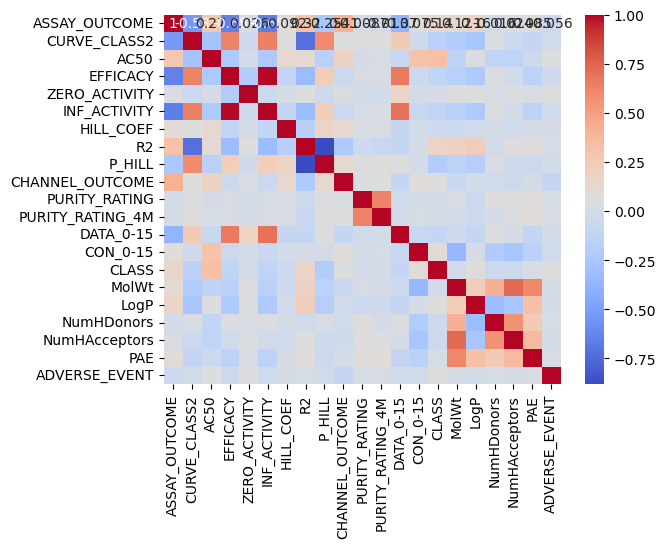

In [160]:
correlation_matrix = corr_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [162]:
X = dataA.drop(columns=['ADVERSE_EVENT', 'SAMPLE_NAME', 'SMILES'])
y = dataA['ADVERSE_EVENT']

In [164]:
# Train the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [166]:
print(pd.Series(y_test).value_counts())

ADVERSE_EVENT
1    2601
0       6
Name: count, dtype: int64


In [168]:
# The class distribution before resampling
print(pd.Series(y_train).value_counts())

ADVERSE_EVENT
1    10394
0       31
Name: count, dtype: int64


In [170]:
# Combination of SMOTE and ENN
smote_enn = SMOTEENN(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

In [172]:
# The class distribution after resampling
print(pd.Series(y_resampled).value_counts())

ADVERSE_EVENT
0    10394
1    10319
Name: count, dtype: int64


In [174]:
# The Model Training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [176]:
# The model performance evaluation on the test set
Accuracy = model.score(X_test, y_test)
print(f'Accuracy with Selected Features: {Accuracy * 100:.2f}%')

Accuracy with Selected Features: 99.85%


In [178]:
# Feature importance scores
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_resampled.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

             Feature  Importance
2               AC50    0.186474
9    CHANNEL_OUTCOME    0.151673
0      ASSAY_OUTCOME    0.142452
3           EFFICACY    0.109205
14             CLASS    0.106483
5       INF_ACTIVITY    0.078194
13          CON_0-15    0.043588
1       CURVE_CLASS2    0.037205
12         DATA_0-15    0.028941
4      ZERO_ACTIVITY    0.028250
8             P_HILL    0.018777
16              LogP    0.013461
17        NumHDonors    0.012569
18     NumHAcceptors    0.010586
15             MolWt    0.007920
7                 R2    0.007086
19               PAE    0.005586
11  PURITY_RATING_4M    0.005536
6          HILL_COEF    0.004280
10     PURITY_RATING    0.001734


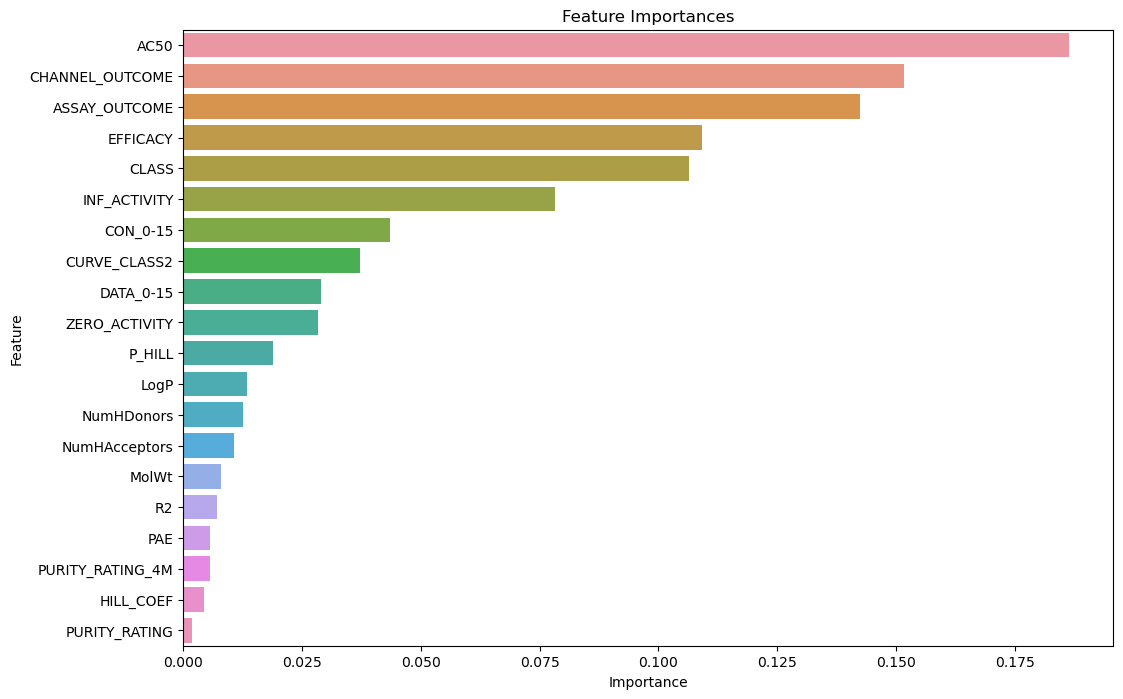

In [180]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

In [182]:
# Important features selection using the trained model
selector = SelectFromModel(model, prefit=True)
X_train_selected = selector.transform(X_resampled)
X_test_selected = selector.transform(X_test)

In [184]:
# The new model training with selected features
model_selected = RandomForestClassifier(n_estimators=100, random_state=42)
model_selected.fit(X_train_selected, y_resampled)

RandomForestClassifier(random_state=42)

In [186]:
# Model performance evaluation on the test set
accuracy_selected = model_selected.score(X_test_selected, y_test)
print(f'Accuracy with Selected Features: {accuracy_selected * 100:.2f}%')

Accuracy with Selected Features: 99.69%


In [188]:
# Cross-validation
cv_scores = cross_val_score(model_selected, X, y, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean() * 100:.2f}%')

Cross-Validation Accuracy Scores: [0.99808209 0.9976985  0.99808135 0.99808135 0.99961627]
Mean Cross-Validation Accuracy: 99.83%


In [190]:
# RFE initialisation
rfe = RFE(estimator=model_selected, n_features_to_select=4, step=1)

In [192]:
# Fit RFE
rfe.fit(X_resampled, y_resampled)

RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=4)

In [194]:
# Creating the ranking of the features
ranking = rfe.ranking_
selected_features = X_resampled.columns[rfe.support_]

In [198]:
# Creating a DataFrame for better visualization
rfe_df = pd.DataFrame({
    'Feature': X_resampled.columns,
    'Ranking': ranking
}).sort_values(by='Ranking', ascending=True)

print(rfe_df)
print(f'Selected Features: {selected_features}')

             Feature  Ranking
0      ASSAY_OUTCOME        1
3           EFFICACY        1
9    CHANNEL_OUTCOME        1
2               AC50        1
14             CLASS        2
5       INF_ACTIVITY        3
13          CON_0-15        4
1       CURVE_CLASS2        5
16              LogP        6
4      ZERO_ACTIVITY        7
12         DATA_0-15        8
18     NumHAcceptors        9
17        NumHDonors       10
8             P_HILL       11
11  PURITY_RATING_4M       12
15             MolWt       13
7                 R2       14
6          HILL_COEF       15
19               PAE       16
10     PURITY_RATING       17
Selected Features: Index(['ASSAY_OUTCOME', 'AC50', 'EFFICACY', 'CHANNEL_OUTCOME'], dtype='object')


# Ensemble Learning

In [201]:
# Cross-Validation Setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [203]:
# Function to train and evaluate Models
def train_and_evaluate_models(X_train, X_test, y_train, y_test, model_list):
    results = {}
    accuracies = []
    model_names = []
    # List of models to include in the condition
    models_for_classification = (XGBClassifier, SVC, RandomForestClassifier, MLPClassifier)
    models_for_regression = (MLPRegressor, RandomForestRegressor, LinearRegression, GradientBoostingRegressor)    
    
    for model_name, model in model_list.items():
        # Only run the section if the model is an instance of the models_for_classification
        if isinstance(model, models_for_classification):
            # Hyperparameter tuning using GridSearchCV
            param_grid = {}
 
            if isinstance(model, XGBClassifier):
                param_grid = {
                    'n_estimators': [50, 100], 
                    'max_depth': [None, 10, 20], 
                    'min_samples_split': [2, 5, 10],
                    'learning_rate': [0.01, 0.1, 0.2]
                }
            elif isinstance(model, SVC):
                param_grid = {
                    'kernel': ['linear', 'poly', 'rbf'],
                    'C': [0.1, 1, 10]
                }
            elif isinstance(model, RandomForestClassifier):
                param_grid = {
                    'n_estimators': [50, 100], 
                    'max_depth': [None, 10, 20], 
                    'min_samples_split': [2, 5, 10]
                }
            elif isinstance(model, MLPClassifier):
                param_grid = {
                    'hidden_layer_sizes': [(10,), (25,), (50,)],
                    'activation': ['relu', 'tanh'],
                    'solver': ['adam', 'sgd']
                }
 
            
            if param_grid:
                grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='accuracy')
                grid_search.fit(X_train, y_train)
                model = grid_search.best_estimator_
 
        # Train the best model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Only run the section if the model is an instance of the models_for_regression
        if isinstance(model, models_for_regression):
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            results[model_name] = {"MSE": mse, "R2 Score": r2}
            print(f"{model_name} MSE: {mse:.2f}, R² Score: {r2:.2f}")
            # Visualization
            plt.figure(figsize=(10, 6))
            plt.scatter(y_test, y_pred, alpha=0.7)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
            plt.title(f'Actual vs Predicted Values for {model_name}')
            plt.xlabel('Actual Values')
            plt.ylabel('Predicted Values')
            plt.grid()
            plt.show()
            print("\n" + "-"*50 + "\n")
        else:
            accuracy = accuracy_score(y_test, y_pred)
            conf_matrix = confusion_matrix(y_test, y_pred)
            class_report = classification_report(y_test, y_pred)
            results[model_name] = {"Accuracy": accuracy, "Confusion Matrix": conf_matrix, 
            "Classification Report": class_report}
            print(f"{model_name} Accuracy: {accuracy * 100:.2f}%")
            print(f"{model_name} Confusion Matrix:\n{conf_matrix}")
            print(f"{model_name} Classification Report:\n{class_report}")
            accuracies.append(accuracy)  
            model_names.append(model_name)
    # Plotting the accuracies as a bar chart only if there are models_for_classification
    if model_names and accuracies:
        plt.figure(figsize=(10, 6))
        plt.bar(model_names, accuracies, color= 'skyblue')
        plt.title('Comparative Analysis of Model Accuracies')
        plt.xlabel('Models')
        plt.ylabel('Accuracy')
        plt.ylim(0.0, 1.05)
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.show()
 
    return results

In [205]:
# Models to use for classification
classification_models = {
    "SVM": SVC(kernel='poly', probability=True, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(25, 18, 10, 5), activation='relu', solver='adam', max_iter=500, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

In [207]:
# Models to use for regression
regression_models = {
    "MLP": MLPRegressor(max_iter=500, random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

Training for ASSAY_OUTCOME
SVM Accuracy: 93.82%
SVM Confusion Matrix:
[[ 235    0    0    0    0    0    0    0]
 [   0  116    1    0    0    0    0   46]
 [   0    0 1421    0    0    0    0    0]
 [   0    0    3   18    1    0    0    0]
 [   0    0    0    0  129    0    1    0]
 [   3    0    0    0   17    6    1    1]
 [   0    0    0    1    1    0  124   15]
 [   0   35    1    0    0    0   34  397]]
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       235
           1       0.77      0.71      0.74       163
           2       1.00      1.00      1.00      1421
           3       0.95      0.82      0.88        22
           4       0.87      0.99      0.93       130
           5       1.00      0.21      0.35        28
           6       0.78      0.88      0.82       141
           7       0.86      0.85      0.86       467

    accuracy                           0.94      2607
   macro avg    

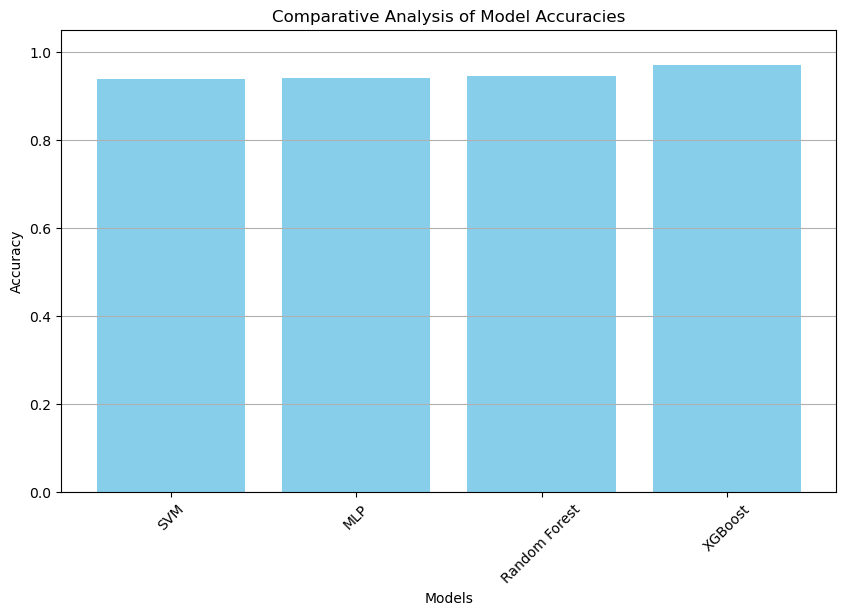

In [209]:
# Training and evaluation for ASSAY_OUTCOME (classification)
X1 = dataA.drop(columns=['ASSAY_OUTCOME', 'SAMPLE_NAME', 'SMILES'])
y1 = dataA['ASSAY_OUTCOME']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
print("Training for ASSAY_OUTCOME")
results_assay_outcome = train_and_evaluate_models(X1_train, X1_test, y1_train, y1_test, classification_models)


Training for CHANNEL_OUTCOME
SVM Accuracy: 97.47%
SVM Confusion Matrix:
[[ 237    0    0    0    3    0]
 [   0  517    1    0    0   12]
 [   0    0 1421    0    0    0]
 [   0    0    1   21    0    0]
 [   1    0    0    0  152    0]
 [   0   47    0    0    1  193]]
SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       240
           1       0.92      0.98      0.95       530
           2       1.00      1.00      1.00      1421
           3       1.00      0.95      0.98        22
           4       0.97      0.99      0.98       153
           5       0.94      0.80      0.87       241

    accuracy                           0.97      2607
   macro avg       0.97      0.95      0.96      2607
weighted avg       0.97      0.97      0.97      2607

MLP Accuracy: 97.20%
MLP Confusion Matrix:
[[ 237    0    0    0    3    0]
 [   1  499    0    0    0   30]
 [   0    0 1421    0    0    0]
 [   0    0    0

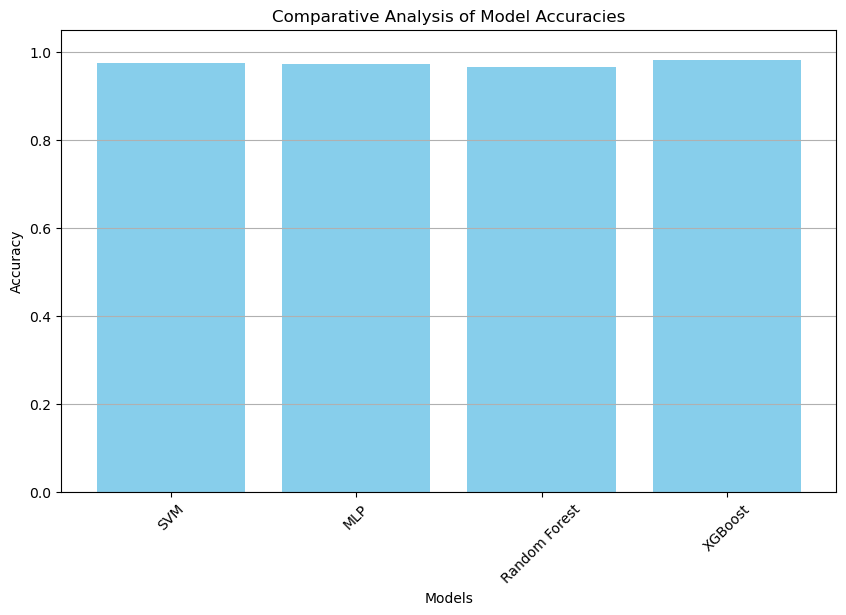

In [211]:
# Training and evaluation for CHANNEL_OUTCOME (classification)
X2 = dataA.drop(columns=['CHANNEL_OUTCOME', 'SAMPLE_NAME', 'SMILES'])
y2 = dataA['CHANNEL_OUTCOME']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
print("\nTraining for CHANNEL_OUTCOME")
results_channel_outcome = train_and_evaluate_models(X2_train, X2_test, y2_train, y2_test, classification_models)


Training for AC50
MLP MSE: 0.12, R² Score: 0.87


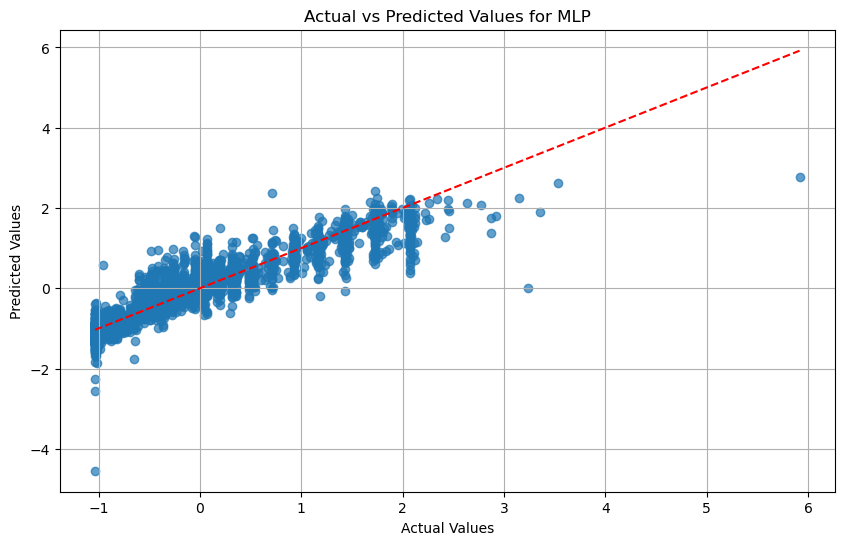


--------------------------------------------------

Random Forest MSE: 0.14, R² Score: 0.86


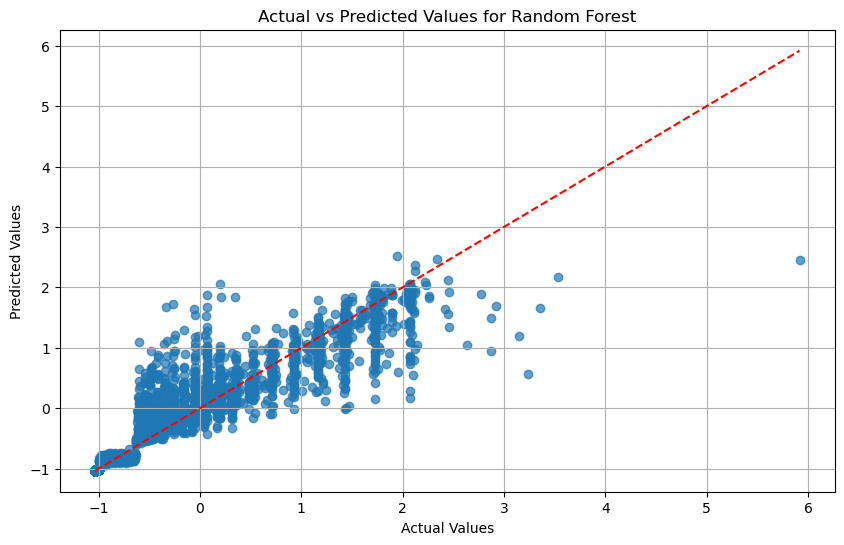


--------------------------------------------------

Linear Regression MSE: 0.66, R² Score: 0.30


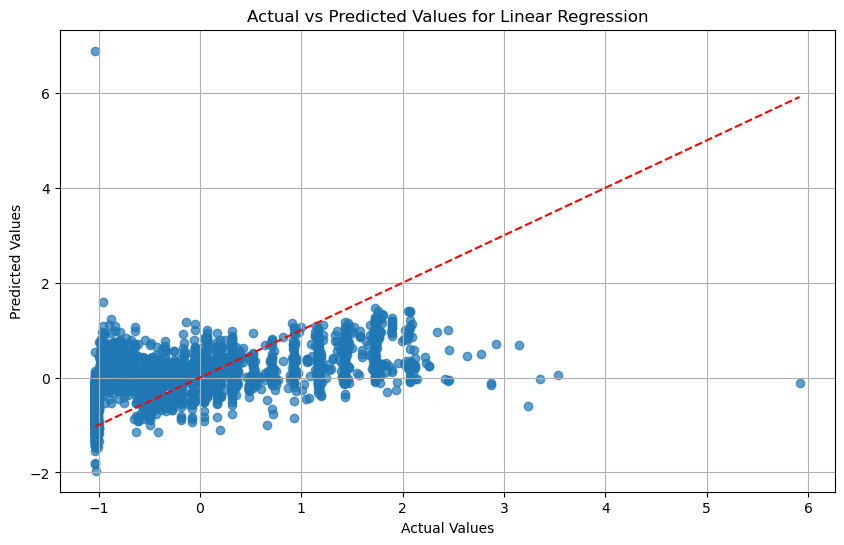


--------------------------------------------------

Gradient Boosting MSE: 0.19, R² Score: 0.80


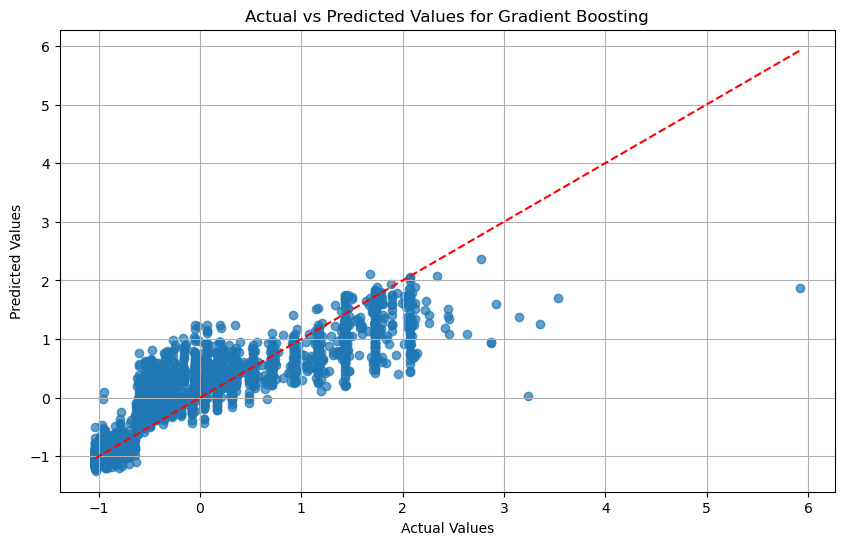


--------------------------------------------------



In [213]:
# Training and evaluation for AC50 (regression)
X3 = dataA.drop(columns=['AC50', 'SAMPLE_NAME', 'SMILES'])
y3 = dataA['AC50']
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)
print("\nTraining for AC50")
results_ac50 = train_and_evaluate_models(X3_train, X3_test, y3_train, y3_test, regression_models)


Training for EFFICACY
MLP MSE: 0.00, R² Score: 1.00


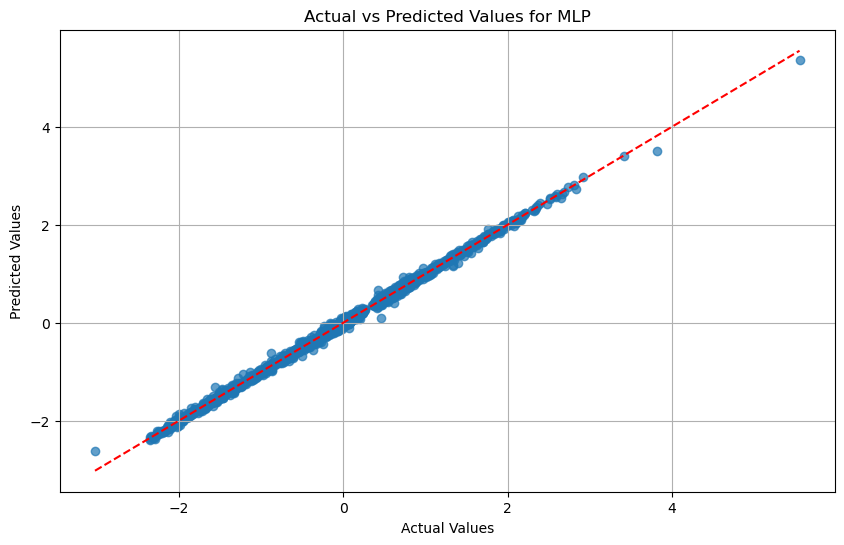


--------------------------------------------------

Random Forest MSE: 0.00, R² Score: 1.00


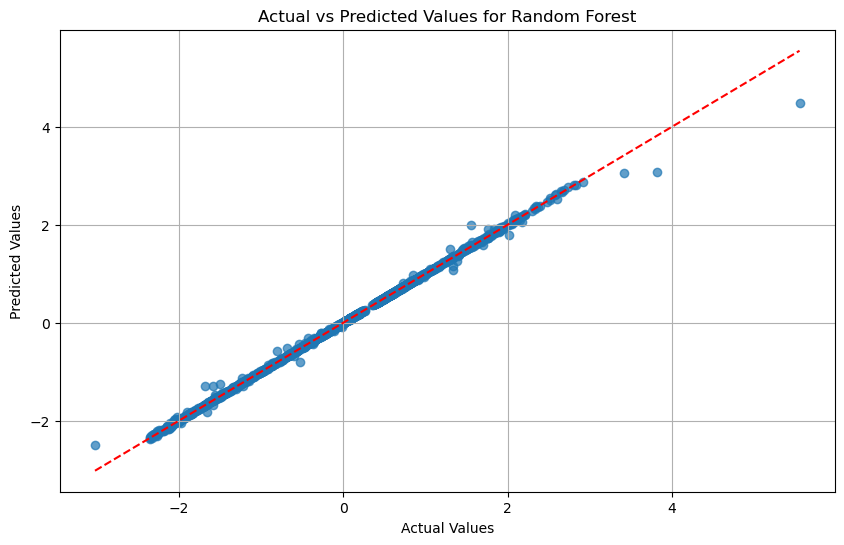


--------------------------------------------------

Linear Regression MSE: 0.00, R² Score: 1.00


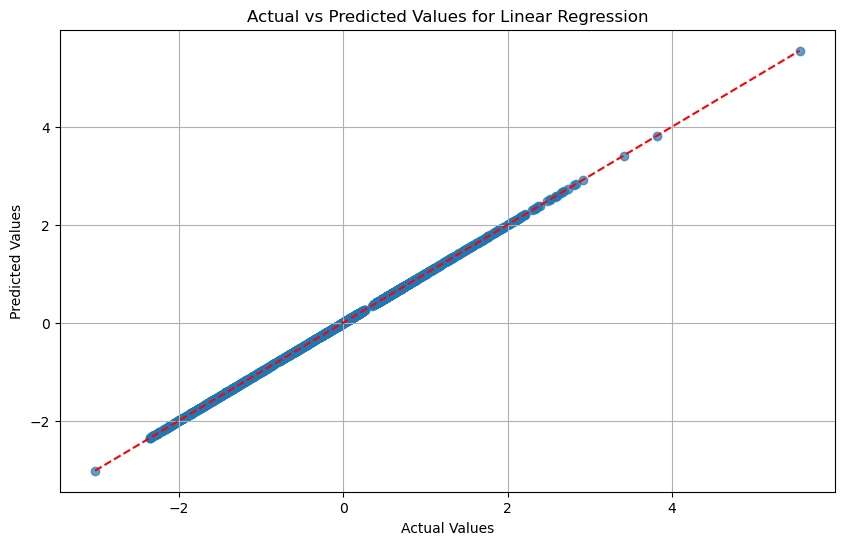


--------------------------------------------------

Gradient Boosting MSE: 0.00, R² Score: 1.00


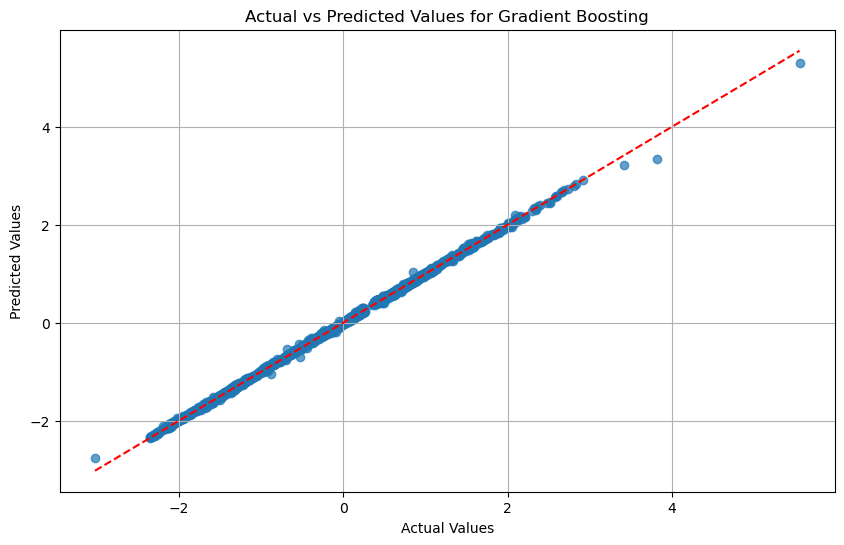


--------------------------------------------------



In [215]:
# Training and evaluation for EFFICACY (regression)
X4 = dataA.drop(columns=['EFFICACY', 'SAMPLE_NAME', 'SMILES'])
y4 = dataA['EFFICACY']
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42)
print("\nTraining for EFFICACY")
results_efficacy = train_and_evaluate_models(X4_train, X4_test, y4_train, y4_test, regression_models)

In [217]:
# Predictions from the best models found in classification models
XGBoost= XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
param_grid = {
                'n_estimators': [50, 100], 
                'max_depth': [None, 10, 20], 
                'min_samples_split': [2, 5, 10],
                'learning_rate': [0.01, 0.1, 0.2]
            }
grid_search = GridSearchCV(XGBoost, param_grid, cv=kf)

In [219]:
grid_search.fit(X1_train, y1_train)
AO_model = grid_search.best_estimator_

In [221]:
grid_search.fit(X2_train, y2_train)
CO_model = grid_search.best_estimator_

In [223]:
# Predictions from the best models found in regression models
ac50_model = regression_models["MLP"]
efficacy_model = regression_models["Linear Regression"]

In [225]:
ac50_model.fit(X3_train, y3_train)

MLPRegressor(max_iter=500, random_state=42)

In [227]:
efficacy_model.fit(X4_train, y4_train)

LinearRegression()

In [229]:
# predictions from the best models training set
AO_predictions_train = AO_model.predict(X1_train)
CO_predictions_train = CO_model.predict(X2_train)
ac50_predictions_train = ac50_model.predict(X3_train)
efficacy_predictions_train = efficacy_model.predict(X4_train)

In [231]:
# predictions from the best models test set
AO_predictions_test = AO_model.predict(X1_test)
CO_predictions_test = CO_model.predict(X2_test)
ac50_predictions_test = ac50_model.predict(X3_test)
efficacy_predictions_test = efficacy_model.predict(X4_test)

In [233]:
# Safety Model Preparation
X_safety = dataA.drop(columns=['ADVERSE_EVENT', 'SAMPLE_NAME', 'SMILES'])
y_safety = dataA['ADVERSE_EVENT']
X_safety_train, X_safety_test, y_safety_train, y_safety_test = train_test_split(X_safety, y_safety, test_size=0.2, random_state=42)

In [235]:
# Combine predictions for the training set
combined_train_features = np.column_stack((X_safety_train, AO_predictions_train, CO_predictions_train, 
                                           ac50_predictions_train, efficacy_predictions_train))

In [237]:
# Combine predictions for the test set
combined_test_features = np.column_stack((X_safety_test, AO_predictions_test, CO_predictions_test, 
                                          ac50_predictions_test, efficacy_predictions_test))

In [239]:
# Defining the DNN model
def create_dnn_model(input_shape):
    model = keras.Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=input_shape))  # Remove extra tuple
    model.add(layers.Dropout(0.2))  # Dropout layer for regularization
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # For binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [241]:
input_shape = (combined_train_features.shape[1],)
safety_model = KerasClassifier(build_fn=create_dnn_model, input_shape=input_shape, epochs=50, batch_size=32, verbose=0)

In [243]:
# Safety model Training
safety_model.fit(combined_train_features, y_safety_train, validation_split=0.2)

KerasClassifier(
	model=None
	build_fn=<function create_dnn_model at 0x000001F29B74DBC0>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
	input_shape=(24,)
	class_weight=None
)

In [245]:
# Safety model evaluation
safety_predictions = safety_model.predict(combined_test_features)
print("Safety Model Classification Report:\n", classification_report(y_safety_test, safety_predictions))
print("Safety Model Confusion Matrix:\n", confusion_matrix(y_safety_test, safety_predictions))
accuracy_safety = accuracy_score(y_safety_test, safety_predictions)
print("Safety Model Accuracy: {:.2f}%".format(accuracy_safety * 100))

Safety Model Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       1.00      1.00      1.00      2601

    accuracy                           1.00      2607
   macro avg       1.00      0.83      0.90      2607
weighted avg       1.00      1.00      1.00      2607

Safety Model Confusion Matrix:
 [[   4    2]
 [   0 2601]]
Safety Model Accuracy: 99.92%


In [247]:
# Using the Safety model to predict ADVERSE_EVENT on the whole dataset
AO_predictions_full = AO_model.predict(X1)
CO_predictions_full = CO_model.predict(X2)
ac50_predictions_full = ac50_model.predict(X3)
efficacy_predictions_full = efficacy_model.predict(X4)

In [249]:
combined_features_full = np.column_stack((X_safety, AO_predictions_full, CO_predictions_full, 
                                          ac50_predictions_full, efficacy_predictions_full))

In [251]:
# Cross-validation
cv_scores = cross_val_score(safety_model, combined_features_full, y_safety, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score: {:.2f}%".format(cv_scores.mean() * 100))

Cross-validation scores: [0.99808209 0.99693134 0.99808135 0.99808135 0.99808135]
Mean cross-validation score: 99.79%


In [253]:
# Probability predictions for the positive class (ADVERSE_EVENT = 1)
safety_probabilities = safety_model.predict_proba(combined_test_features)[:, 1]

In [255]:
# ROC curve and AUC area
fpr, tpr, _ = roc_curve(y_safety_test, safety_probabilities)
roc_auc = auc(fpr, tpr)

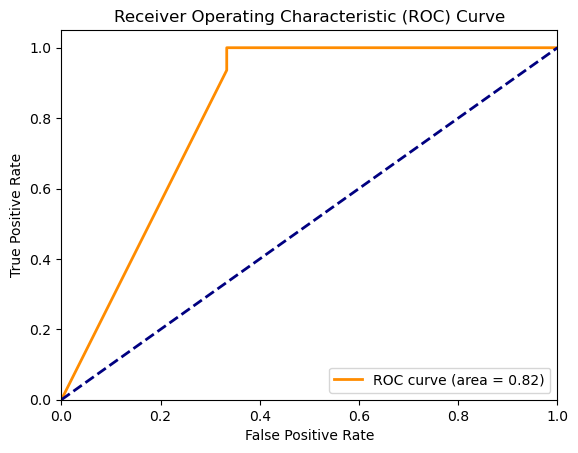

In [257]:
# Plotting ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [259]:
optimized_leads = dataA.copy()
optimized_leads['Predicted_ADVERSE_EVENT'] = safety_model.predict(combined_features_full)

In [261]:
# Defining criteria for lead compound
optimized_lead_compound_condition = (
    (optimized_leads['PURITY_RATING'] == 0) &
    (optimized_leads['PURITY_RATING_4M'] == 0) &
    (optimized_leads['CLASS'] == 0) &
    (optimized_leads['PAE'] == 0) &
    (optimized_leads['Predicted_ADVERSE_EVENT'] == 0)
)

In [263]:
# Selection of optimised lead compounds
optimized_lead_compound = optimized_leads[optimized_lead_compound_condition]

In [265]:
# Sort and select top compounds based on desired criteria, e.g., EFFICACY
Top_compounds = optimized_lead_compound.sort_values(by='EFFICACY', ascending=False).head(5)

In [267]:
optimized_lead_compound.head()

,ASSAY_OUTCOME,CURVE_CLASS2,AC50,EFFICACY,ZERO_ACTIVITY,INF_ACTIVITY,HILL_COEF,R2,P_HILL,CHANNEL_OUTCOME,...,DATA_0-15,CON_0-15,CLASS,MolWt,LogP,NumHDonors,NumHAcceptors,PAE,ADVERSE_EVENT,Predicted_ADVERSE_EVENT
823,3,-0.173351,-1.018743,0.783090,-0.409606,0.741688,1.167218,0.692023,-0.848919,3,...,0.605521,0.559420,0,0.086606,1.026932,-0.764607,-0.618392,0,0,0
3528,7,0.807876,-1.035955,0.522992,-1.736758,0.309264,0.542949,-1.032686,0.903008,1,...,-0.004923,0.762603,0,0.678704,0.381271,-0.764607,1.506751,0,0,0
7173,6,0.807876,-1.035664,0.782882,-2.676535,0.453189,-1.544845,0.541704,-0.797488,5,...,0.138288,0.573028,0,0.768932,0.974785,-0.764607,0.089989,0,0,0
7333,1,0.807876,-1.036024,0.579489,0.005661,0.588118,1.167218,-0.470387,0.310903,1,...,1.070042,0.814939,0,0.073182,0.648584,-0.147207,-0.618392,0,0,0
11570,6,0.807876,-1.028293,0.505430,-0.394303,0.462184,1.167218,-0.337544,-0.013674,5,...,0.210284,0.578517,0,-0.433801,0.448590,-0.147207,-0.264201,0,0,0


In [269]:
print("Top Optimized Lead Compounds:")
print(Top_compounds[['SAMPLE_NAME', 'SMILES', 'ASSAY_OUTCOME', 'CHANNEL_OUTCOME', 'CLASS', 
                     'PURITY_RATING', 'PURITY_RATING_4M', 'EFFICACY', 'PAE', 'ADVERSE_EVENT']])

Top Optimized Lead Compounds:
                   SAMPLE_NAME  \
17067             Oxymetholone   
15704             Oxymetholone   
21339  2-Mercaptobenzothiazole   
20412             Progesterone   
823               Progesterone   

                                                  SMILES  ASSAY_OUTCOME  \
17067  O=C3C[C@@H]4CC[C@@H]2[C@H](CC[C@@]1(C)[C@H]2CC...              7   
15704  O=C3C[C@@H]4CC[C@@H]2[C@H](CC[C@@]1(C)[C@H]2CC...              7   
21339                                     Sc1nc2ccccc2s1              6   
20412  CC(=O)[C@H]2CC[C@H]3[C@@H]4CCC1=CC(=O)CC[C@]1(...              3   
823    CC(=O)[C@H]2CC[C@H]3[C@@H]4CCC1=CC(=O)CC[C@]1(...              3   

       CHANNEL_OUTCOME  CLASS  PURITY_RATING  PURITY_RATING_4M  EFFICACY  PAE  \
17067                5      0              0                 0  1.047853    0   
15704                5      0              0                 0  0.955259    0   
21339                5      0              0                 0  0.81574

In [271]:
# Count occurrences of each value in the Predicted_ADVERSE_EVENT column
predicted_event_count = optimized_leads['Predicted_ADVERSE_EVENT'].value_counts()
actual_event_count = optimized_leads['ADVERSE_EVENT'].value_counts()

print("Predicted Adverse Event Counts:")
print(predicted_event_count)

print("\nActual Adverse Event Counts:")
print(actual_event_count)

Predicted Adverse Event Counts:
Predicted_ADVERSE_EVENT
1    13002
0       30
Name: count, dtype: int64

Actual Adverse Event Counts:
ADVERSE_EVENT
1    12995
0       37
Name: count, dtype: int64


In [273]:
optimized_leads['Comparison'] = optimized_leads['Predicted_ADVERSE_EVENT'] == optimized_leads['ADVERSE_EVENT']
comparison_counts = optimized_leads['Comparison'].value_counts()

print("\nComparison of Predictions vs Actuals:")
print(comparison_counts)


Comparison of Predictions vs Actuals:
Comparison
True     13023
False        9
Name: count, dtype: int64


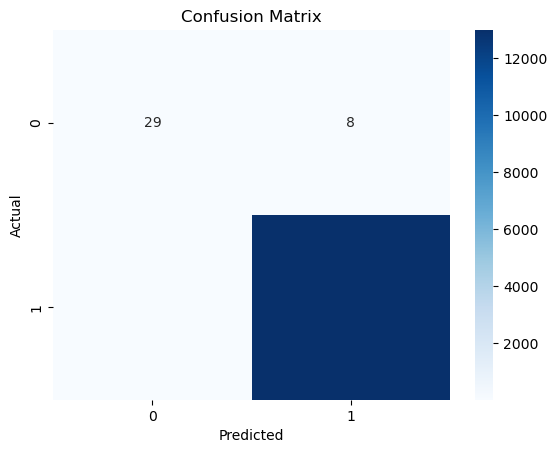

In [275]:
# Confusion matrix Heatmap
conf_matrix = confusion_matrix(optimized_leads['ADVERSE_EVENT'], optimized_leads['Predicted_ADVERSE_EVENT'])

# Plotting the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Transfer Learning

# Utilising Viability Dataset in the Transfer Learning

In [279]:
data_TL = Final_viability_data

In [281]:
# Splitting up data for individual models
X_TL_1 = data_TL.drop(columns=['ASSAY_OUTCOME', 'SAMPLE_NAME', 'SMILES'])
y_TL_1 = data_TL['ASSAY_OUTCOME']
X_TL_2 = data_TL.drop(columns=['CHANNEL_OUTCOME', 'SAMPLE_NAME', 'SMILES'])
y_TL_2 = data_TL['CHANNEL_OUTCOME']
X_TL_3 = data_TL.drop(columns=['AC50', 'SAMPLE_NAME', 'SMILES'])
y_TL_3 = data_TL['AC50']
X_TL_4 = data_TL.drop(columns=['EFFICACY', 'SAMPLE_NAME', 'SMILES'])
y_TL_4 = data_TL['EFFICACY']

In [283]:
X_safety_TL = data_TL.drop(columns=['ADVERSE_EVENT', 'SAMPLE_NAME', 'SMILES'])
y_safety_TL = data_TL['ADVERSE_EVENT']

In [285]:
X_TL_1_train, X_TL_1_test, y_TL_1_train, y_TL_1_test = train_test_split(X_TL_1, y_TL_1, test_size=0.2, random_state=42)
X_TL_2_train, X_TL_2_test, y_TL_2_train, y_TL_2_test = train_test_split(X_TL_2, y_TL_2, test_size=0.2, random_state=42)
X_TL_3_train, X_TL_3_test, y_TL_3_train, y_TL_3_test = train_test_split(X_TL_3, y_TL_3, test_size=0.2, random_state=42)
X_TL_4_train, X_TL_4_test, y_TL_4_train, y_TL_4_test = train_test_split(X_TL_4, y_TL_4, test_size=0.2, random_state=42)

In [287]:
X_safety_TL_train, X_safety_TL_test, y_safety_TL_train, y_safety_TL_test = train_test_split(X_safety_TL, y_safety_TL, test_size=0.2, random_state=42)

In [289]:
# Generating predictions on the test set
AO_predictions_test_TL = AO_model.predict(X_TL_1_test)
CO_predictions_test_TL = CO_model.predict(X_TL_2_test)
ac50_predictions_test_TL = ac50_model.predict(X_TL_3_test)
efficacy_predictions_test_TL = efficacy_model.predict(X_TL_4_test)

In [291]:
# Combining original features with predictions for the test set
combined_test_features_TL = np.column_stack((X_safety_TL_test, AO_predictions_test_TL, CO_predictions_test_TL, 
                                          ac50_predictions_test_TL, efficacy_predictions_test_TL))

In [293]:
# The Safety model Evaluation
safety_predictions_TL = safety_model.predict(combined_test_features_TL)
print("Safety Model Classification Report:\n", classification_report(y_safety_TL_test, safety_predictions_TL))
print("Safety Model Confusion Matrix:\n", confusion_matrix(y_safety_TL_test, safety_predictions_TL))
accuracy_safety = accuracy_score(y_safety_TL_test, safety_predictions_TL)
print("Safety Model Accuracy: {:.2f}%".format(accuracy_safety * 100))

Safety Model Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      1.00      1.00      2084

    accuracy                           1.00      2087
   macro avg       1.00      0.83      0.90      2087
weighted avg       1.00      1.00      1.00      2087

Safety Model Confusion Matrix:
 [[   2    1]
 [   0 2084]]
Safety Model Accuracy: 99.95%


In [295]:
# Using the Safety model to predict ADVERSE_EVENT on the whole dataset
AO_predictions_full_TL = AO_model.predict(X_TL_1)
CO_predictions_full_TL = CO_model.predict(X_TL_2)
ac50_predictions_full_TL = ac50_model.predict(X_TL_3)
efficacy_predictions_full_TL = efficacy_model.predict(X_TL_4)

In [297]:
combined_features_full_TL = np.column_stack((X_safety_TL, AO_predictions_full_TL, CO_predictions_full_TL, 
                                          ac50_predictions_full_TL, efficacy_predictions_full_TL))

In [299]:
# Cross-validation
cv_scores_TL = cross_val_score(safety_model, combined_features_full_TL, y_safety_TL, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score: {:.2f}%".format(cv_scores_TL.mean() * 100))

Cross-validation scores: [0.99808209 0.99693134 0.99808135 0.99808135 0.99808135]
Mean cross-validation score: 99.95%


In [301]:
# Probability predictions for the positive class (ADVERSE_EVENT = 1)
safety_probabilities_TL = safety_model.predict_proba(combined_test_features_TL)[:, 1]

In [303]:
# ROC curve and AUC area
fpr, tpr, _ = roc_curve(y_safety_TL_test, safety_probabilities_TL)
roc_auc = auc(fpr, tpr)

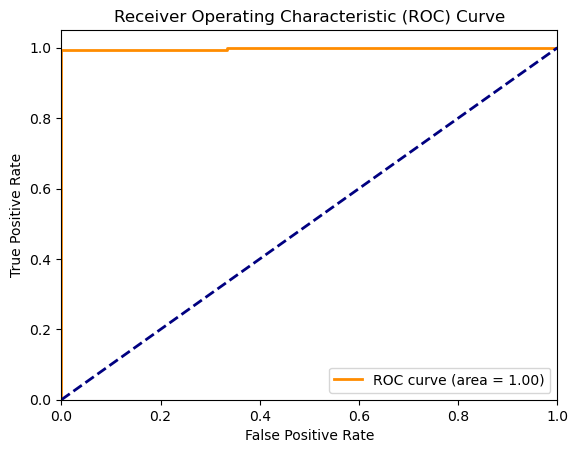

In [305]:
# Plotting ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [307]:
optimized_leads_TL = data_TL.copy()
optimized_leads_TL['Predicted_ADVERSE_EVENT'] = safety_model.predict(combined_features_full_TL)

In [309]:
# Defining criteria for lead compound
optimized_lead_compound_condition_TL = (
    (optimized_leads_TL['PURITY_RATING'] == 0) &
    (optimized_leads_TL['PURITY_RATING_4M'] == 0) &
    (optimized_leads_TL['CLASS'] == 0) &
    (optimized_leads_TL['PAE'] == 0) &
    (optimized_leads_TL['Predicted_ADVERSE_EVENT'] == 0)
)

In [311]:
# Selection of optimised lead compounds
optimized_lead_compound_TL = optimized_leads_TL[optimized_lead_compound_condition_TL]

In [313]:
# Sort and select top compounds based on desired criteria, e.g., EFFICACY
Top_compounds_TL = optimized_lead_compound_TL.sort_values(by='EFFICACY', ascending=False).head(5)

In [315]:
print("Top Optimized Lead Compounds:")
print(Top_compounds_TL[['SAMPLE_NAME', 'SMILES', 'ASSAY_OUTCOME', 'CHANNEL_OUTCOME', 'CLASS', 
                        'PURITY_RATING', 'PURITY_RATING_4M', 'EFFICACY', 'PAE', 'ADVERSE_EVENT']])

Top Optimized Lead Compounds:
             SAMPLE_NAME                                             SMILES  \
7688           Terbucarb              O=C(Oc1c(cc(C)cc1C(C)(C)C)C(C)(C)C)NC   
15526       Azoxystrobin    O=C(OC)\C(=C\OC)c3ccccc3Oc2cc(Oc1ccccc1C#N)ncn2   
13688  17alpha-Estradiol  Oc3cc4CC[C@@H]1[C@H](CC[C@]2(C)[C@H](O)CC[C@@H...   
19577      4-Octylphenol                                Oc1ccc(CCCCCCCC)cc1   

       ASSAY_OUTCOME  CHANNEL_OUTCOME  CLASS  PURITY_RATING  PURITY_RATING_4M  \
7688               6                5      0              0                 0   
15526              7                1      0              0                 0   
13688              7                5      0              0                 0   
19577              7                5      0              0                 0   

       EFFICACY  PAE  ADVERSE_EVENT  
7688   0.532938    0              0  
15526  0.511741    0              0  
13688  0.483666    0              0  
19577  0.469948 

In [317]:
# Count occurrences of each value in the Predicted_ADVERSE_EVENT column
predicted_event_count_TL = optimized_leads_TL['Predicted_ADVERSE_EVENT'].value_counts()
actual_event_count_TL = optimized_leads_TL['ADVERSE_EVENT'].value_counts()

print("Predicted Adverse Event Counts:")
print(predicted_event_count_TL)

print("\nActual Adverse Event Counts:")
print(actual_event_count_TL)

Predicted Adverse Event Counts:
Predicted_ADVERSE_EVENT
1    10430
0        4
Name: count, dtype: int64

Actual Adverse Event Counts:
ADVERSE_EVENT
1    10425
0        9
Name: count, dtype: int64


In [319]:
optimized_leads_TL['Comparison'] = optimized_leads_TL['Predicted_ADVERSE_EVENT'] == optimized_leads_TL['ADVERSE_EVENT']
comparison_counts_TL = optimized_leads_TL['Comparison'].value_counts()

print("\nComparison of Predictions vs Actuals:")
print(comparison_counts_TL)


Comparison of Predictions vs Actuals:
Comparison
True     10429
False        5
Name: count, dtype: int64


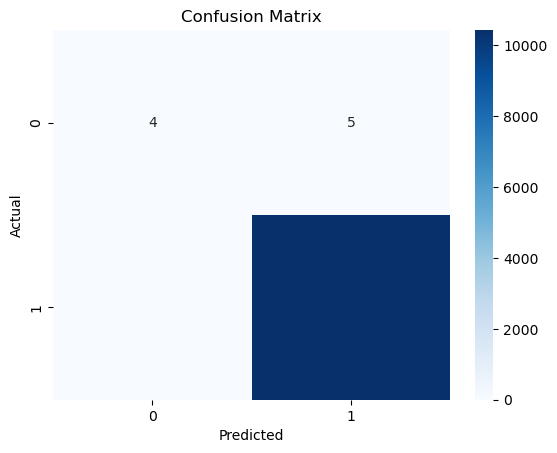

In [321]:
# Confusion matrix Heatmap
conf_matrix_TL = confusion_matrix(optimized_leads_TL['ADVERSE_EVENT'], optimized_leads_TL['Predicted_ADVERSE_EVENT'])

# Plotting the confusion matrix
sns.heatmap(conf_matrix_TL, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()